# Wetlands Segementation Modelling


- It is advised to run this notebook on Kaggle with P100 accelerator
- Add the required dataset for this at https://www.kaggle.com/datasets/abhishekthomas/patches-img-seg-allbands
- A working demo of wetlands segementation can be found at https://huggingface.co/spaces/dcrey7/wetland_segmentation_deeplabsv3plus
- A Model card for the best model for wetlands segementation (Deeplabsv3+) can be found at https://huggingface.co/dcrey7/wetlands_segmentation_deeplabsv3plus

Install all necessary packages for the project

In [ ]:
# !pip install segmentation-models-pytorch albumentations rasterio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.3 MB/s eta 0:00:00:00:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=9900c6a1f836a84feb0ca1efd32c6abc09fc921666cc2444a9da4ad5501be8f8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=4728585ffdd0ce0fd72c3725f6c0124d2924d95b50592e327560cebf87a04a15
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


Importing all necessary packages 

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import rasterio
import albumentations as A
import segmentation_models_pytorch as smp
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
seed=72
np.random.seed(seed)
torch.manual_seed(seed)

# Set seed for CUDA if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Load the data and preprocessing

**Wetlands Image Segmentation Pipeline** <br>

This code establishes a complete pipeline for wetlands image segmentation using PyTorch. The implementation includes data preparation, augmentation, and dataset creation for training a segmentation model.

**Directory Structure Setup** <br>
The code begins by defining the directory paths for the training, validation, and testing datasets. It organizes input images and their corresponding segmentation masks in separate directories for each dataset split.

**Hardware Configuration** <br>
The code automatically detects and configures the available hardware (CUDA GPU or CPU) for optimal performance during training.

**Data Augmentation** <br>
Two augmentation pipelines are implemented using the Albumentations library:

1. **Training Augmentations:** <br>
   - Horizontal and vertical flips with 50% probability
   - Random 90-degree rotations with 50% probability
   - Padding to ensure compatibility with model architecture (128×128 pixels)
   - Random cropping to maintain consistent input dimensions

2. **Validation/Testing Augmentations:** <br>
   - Only necessary processing to ensure image compatibility
   - Padding and center cropping to maintain consistent dimensions

**Custom Dataset Class** <br>
The `WetlandsSegmentationDataset` class extends PyTorch's Dataset to:
- Load paired TIF image and mask files
- Extract RGB channels from potentially multi-band remote sensing data
- Normalize pixel values to the [0,1] range
- Apply the specified augmentations
- Convert data to PyTorch tensors with proper channel ordering

**Data Loading Pipeline** <br>
The code creates three dataset instances (train, validation, test) and wraps them in DataLoader objects that:
- Handle batch processing (batch size of 8)
- Shuffle training data for better generalization
- Maintain sequential ordering for validation and testing data

This implementation ensures efficient data handling for training segmentation models on multi-band wetlands imagery while applying appropriate transformations for model compatibility.

In [3]:
# Set paths - update these to match your Kaggle environment
DATA_DIR = "/kaggle/input/patches-img-seg-allbands/patches_data_allbands"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train/input")
TRAIN_MASK_DIR = os.path.join(DATA_DIR, "train/output")
VAL_IMG_DIR = os.path.join(DATA_DIR, "val/input")
VAL_MASK_DIR = os.path.join(DATA_DIR, "val/output")
TEST_IMG_DIR = os.path.join(DATA_DIR, "test/input")
TEST_MASK_DIR = os.path.join(DATA_DIR, "test/output")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define augmentations
def get_training_augmentation():
    """
    Apply training augmentations: horizontal flip, vertical flip, and rotation
    """
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        # Add padding to ensure dimensions are compatible with the model
        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=0),
        # Random crop to ensure consistent size
        A.RandomCrop(height=128, width=128, always_apply=True),
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """
    Only make sure image sizes are compatible with the model
    """
    test_transform = [
        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.CenterCrop(height=128, width=128, always_apply=True),
    ]
    return A.Compose(test_transform)

# Define the dataset class
class WetlandsSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith('.tif')])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])
        
        # Make sure we have the same number of images and masks
        assert len(self.images) == len(self.masks), "Mismatch between images and masks"
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
        # Read the image using rasterio (get only RGB channels)
        with rasterio.open(img_path) as src:
            red = src.read(1)
            green = src.read(2)
            blue = src.read(3)
        
        # Stack to create RGB image
        image = np.dstack((red, green, blue)).astype(np.float32)
        
        # Normalize to [0, 1]
        if image.max() > 0:
            image = image / image.max()
        
        # Read mask
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)
        
        # Apply augmentations if specified
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert to PyTorch tensors
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        mask = torch.from_numpy(mask).long()
        
        return image, mask

# Create datasets and dataloaders
train_dataset = WetlandsSegmentationDataset(
    TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=get_training_augmentation()
)

val_dataset = WetlandsSegmentationDataset(
    VAL_IMG_DIR, VAL_MASK_DIR, transform=get_validation_augmentation()
)

test_dataset = WetlandsSegmentationDataset(
    TEST_IMG_DIR, TEST_MASK_DIR, transform=get_validation_augmentation()
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Using device: cuda
Train samples: 108, Val samples: 36, Test samples: 36


# Visuals 

**Visualization Functions for Wetlands Image Segmentation**<br>

**Data Visualization**<br>
The code provides comprehensive visualization tools to inspect wetlands segmentation data and model performance. These functions enable thorough analysis throughout the machine learning pipeline.

**Original Data Visualization**<br>
This function displays the original image and its corresponding ground truth mask side by side. It converts PyTorch tensors to NumPy arrays, properly arranges the color channels, and presents the pair in a clear comparative layout. The mask is displayed in grayscale for better visibility of segmentation boundaries.

**Augmented Data Visualization**<br>
This function demonstrates the effectiveness of the data augmentation pipeline by displaying both original and augmented versions of the same image-mask pair. It temporarily disables transformations to retrieve the original data, then applies the augmentations to show the difference. The four-panel display allows for direct comparison between original and augmented versions of both images and masks.

**Training Results Visualization**<br>
This function generates dual plots to track model performance during training. The first plot shows loss curves for both training and validation sets, while the second displays IoU (Intersection over Union) scores - a critical metric for segmentation tasks. These plots help identify overfitting, underfitting, or convergence issues during model training.

**Confusion Matrix Visualization**<br>
This function creates a heatmap representation of the confusion matrix, showing the distribution of true positives, false positives, true negatives, and false negatives. The matrix is specifically labeled for wetland segmentation (Background vs. Wetland) and uses a blue color scheme with numeric annotations for clarity.

**Prediction Visualization**<br>
This function evaluates the trained model on sample data and displays the results in a three-panel comparison: input image, ground truth mask, and predicted mask. It processes multiple samples from the provided dataloader (with a configurable limit) and presents each set on a separate row. This visualization is crucial for qualitative assessment of the model's segmentation performance.

In [4]:

# Visualization function for original data
def visualize_original_data(dataset, idx=0):
    """
    Visualize original image and mask
    """
    image, mask = dataset[idx]
    
    # Convert tensors to numpy for visualization
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot image
    axes[0].imshow(image_np)
    axes[0].set_title("Input Image")
    axes[0].axis("off")
    
    # Plot mask
    axes[1].imshow(mask_np, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualization function for augmented data
def visualize_augmented_data(dataset, idx=0):
    """
    Visualize augmented data samples
    """
    original_transform = dataset.transform
    dataset.transform = None
    orig_image, orig_mask = dataset[idx]
    dataset.transform = original_transform
    aug_image, aug_mask = dataset[idx]
    
    # Convert tensors to numpy for visualization
    orig_image_np = orig_image.permute(1, 2, 0).numpy()
    orig_mask_np = orig_mask.numpy()
    aug_image_np = aug_image.permute(1, 2, 0).numpy()
    aug_mask_np = aug_mask.numpy()
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Plot original image and mask
    axes[0, 0].imshow(orig_image_np)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis("off")
    axes[0, 1].imshow(orig_mask_np, cmap="gray")
    axes[0, 1].set_title("Original Mask")
    axes[0, 1].axis("off")
    
    # Plot augmented image and mask
    axes[1, 0].imshow(aug_image_np)
    axes[1, 0].set_title("Augmented Image")
    axes[1, 0].axis("off")
    axes[1, 1].imshow(aug_mask_np, cmap="gray")
    axes[1, 1].set_title("Augmented Mask")
    axes[1, 1].axis("off")
    
    plt.tight_layout()
    plt.show()



# Function to plot results
def plot_results(train_losses, val_losses, train_ious, val_ious):
    """
    Plot training and validation curves
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot losses
    axes[0].plot(train_losses, label='Train Loss')
    axes[0].plot(val_losses, label='Val Loss')
    axes[0].set_title('Loss Curves')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot IoU scores
    axes[1].plot(train_ious, label='Train IoU')
    axes[1].plot(val_ious, label='Val IoU')
    axes[1].set_title('IoU Curves')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('IoU')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """
    Plot confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Background', 'Wetland'],
                yticklabels=['Background', 'Wetland'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


# Function to visualize predictions
def visualize_predictions(model, dataloader, num_samples=5):
    """
    Visualize predictions vs ground truth
    """
    model.eval()
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
            
            images = images.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float().cpu().numpy()
            
            # For each image in the batch
            for j in range(images.shape[0]):
                if i * dataloader.batch_size + j >= num_samples:
                    break
                
                image = images[j].cpu().numpy().transpose(1, 2, 0)
                mask = masks[j].cpu().numpy()
                pred = preds[j].squeeze()
                
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                
                # Input image
                axes[0].imshow(image)
                axes[0].set_title("Input Image")
                axes[0].axis("off")
                
                # Ground truth mask
                axes[1].imshow(mask, cmap="gray")
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis("off")
                
                # Predicted mask
                axes[2].imshow(pred, cmap="gray")
                axes[2].set_title("Predicted Mask")
                axes[2].axis("off")
                
                plt.tight_layout()
                plt.show()


Visualizing augmented data...


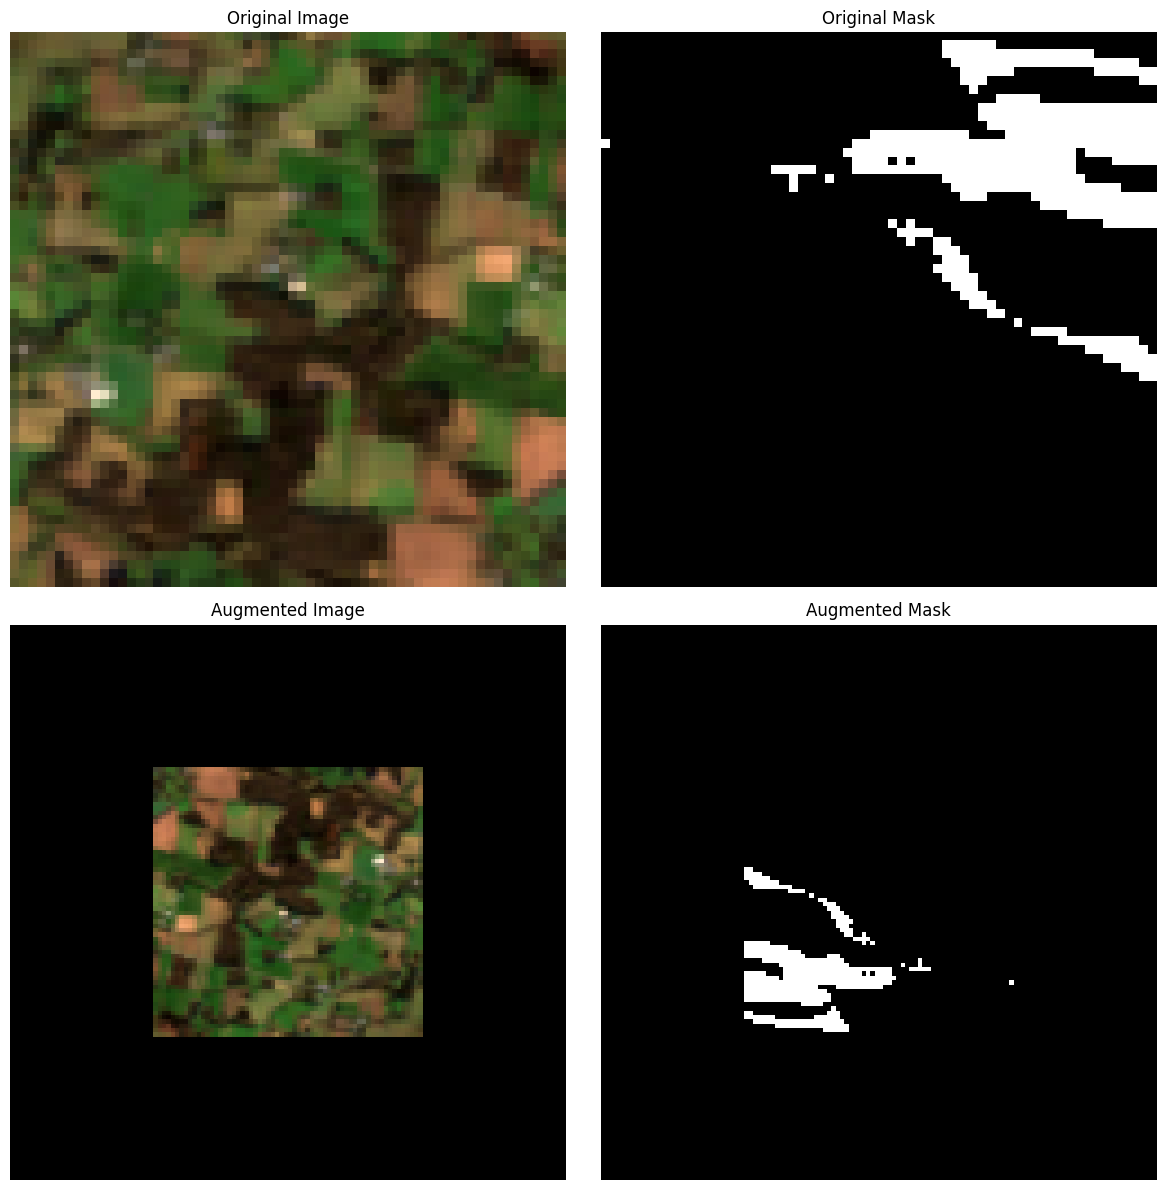

In [5]:
# # 1. Visualize original data
# print("Visualizing original data...")
# visualize_original_data(train_dataset, idx=0)

# 2. Visualize augmented data
print("Visualizing augmented data...")
visualize_augmented_data(train_dataset, idx=0)

# Model Unet

**Model Architecture and Training Pipeline for Wetlands Segmentation**<br>

**Model Configuration**<br>
The code implements a U-Net architecture with ResNet34 backbone pre-trained on ImageNet. This model is configured for binary segmentation of wetlands with RGB input channels and optimized using the Adam optimizer with Dice Loss.

**IoU Metric Implementation**<br>
A custom function calculates the Intersection over Union score for binary segmentation, handling edge cases where both prediction and target are empty regions.

**Training Function**<br>
The training pipeline includes:<br>
- Forward and backward passes with gradient optimization
- IoU calculation for performance tracking
- Early stopping with model checkpointing
- Comprehensive progress reporting

**Prediction and Evaluation**<br>
The code provides functions to generate predictions and evaluate model performance with detailed metrics including:<br>
- Class-specific IoU scores
- Precision, recall, and F1 metrics
- Confusion matrix generation

**Performance Tracking**<br>
A systematic approach for recording model performance metrics across training, validation, and test datasets. Results are stored in a DataFrame with percentage conversion for easier interpretation and comparison between model iterations.

In [6]:
# Define the model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,  # Binary segmentation
)

model = model.to(device)

# Define loss function and optimizer
criterion = smp.losses.DiceLoss('binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Function for IoU calculation
def iou_score(pred, target):
    """
    Calculate IoU score for binary segmentation
    """
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    if union == 0:
        return 1.0  # If both pred and target are empty, IoU is 1
    return (intersection / union).item()


# Training function
def train_model(model,model_name, train_loader, val_loader, criterion, optimizer, num_epochs=5, patience=3):
    """
    Train the model with early stopping
    """
    best_val_loss = float('inf')
    early_stopping_counter = 0
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        epoch_iou = 0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            masks = masks.to(device).float().unsqueeze(1)  # Add channel dimension for binary segmentation
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate IoU
            batch_iou = iou_score(outputs, masks)
            
            epoch_loss += loss.item()
            epoch_iou += batch_iou
        
        avg_train_loss = epoch_loss / len(train_loader)
        avg_train_iou = epoch_iou / len(train_loader)
        train_losses.append(avg_train_loss)
        train_ious.append(avg_train_iou)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_iou = 0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = images.to(device)
                masks = masks.to(device).float().unsqueeze(1)  # Add channel dimension
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Calculate IoU
                batch_iou = iou_score(outputs, masks)
                
                val_loss += loss.item()
                val_iou += batch_iou
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        val_losses.append(avg_val_loss)
        val_ious.append(avg_val_iou)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}, Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}")
        
        #Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            # Save the model
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
            print("  Model saved!")
        else:
            early_stopping_counter += 1
            print(f"  Early stopping counter: {early_stopping_counter}/{patience}")
            if early_stopping_counter >= patience:
                print("Early stopping triggered!")
                break
    
    # Load the best model
    model.load_state_dict(torch.load(f'{model_name}_best_model.pth'))
    
    return model, train_losses, val_losses, train_ious, val_ious

# Prediction function
def predict(model, dataloader):
    """
    Make predictions with the model
    """
    model.eval()
    all_preds = []
    all_masks = []
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Prediction"):
            images = images.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float().cpu().numpy()
            
            all_preds.extend(preds)
            all_masks.extend(masks.unsqueeze(1).numpy())
    
    return np.array(all_preds), np.array(all_masks)

# Evaluation function
def evaluate_model(model, dataloader, name=""):
    """
    Evaluate model performance
    """
    model.eval()
    total_iou = 0
    preds_list = []
    masks_list = []
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc=f"Evaluating {name}"):
            images = images.to(device)
            masks = masks.to(device).float().unsqueeze(1)  # Add channel dimension
            
            outputs = model(images)
            batch_iou = iou_score(outputs, masks)
            total_iou += batch_iou
            
            # Store predictions and masks for confusion matrix
            preds = (outputs > 0.5).float().cpu().numpy().flatten()
            masks_np = masks.cpu().numpy().flatten()
            
            preds_list.extend(preds)
            masks_list.extend(masks_np)
    
    avg_iou = total_iou / len(dataloader)
    
    # Calculate confusion matrix
    cm = confusion_matrix(masks_list, preds_list)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # IoU for each class
    bg_iou = tn / (tn + fp + fn) if (tn + fp + fn) > 0 else 0
    wetland_iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    mean_iou = (bg_iou + wetland_iou) / 2
    
    print(f"\n{name} Metrics:")
    print(f"  Average IoU: {avg_iou:.4f}")
    print(f"  Background IoU: {bg_iou:.4f}")
    print(f"  Wetland IoU: {wetland_iou:.4f}")
    print(f"  Mean IoU: {mean_iou:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    
    return avg_iou, cm, bg_iou, wetland_iou, mean_iou


results_df = pd.DataFrame(columns=[
            'model_name', 'total_epochs',
            'train_bg_iou', 'train_wetland_iou', 'train_mean_iou',
            'val_bg_iou', 'val_wetland_iou', 'val_mean_iou',
            'test_bg_iou', 'test_wetland_iou', 'test_mean_iou'
        ])

def track_model_performance(results_df, model_name, total_epochs, 
                           train_bg_iou, train_wetland_iou, train_mean_iou,
                           val_bg_iou, val_wetland_iou, val_mean_iou,
                           test_bg_iou, test_wetland_iou, test_mean_iou):
    # Create DataFrame if it doesn't exist
    # if results_df is None:
    #     results_df = pd.DataFrame(columns=[
    #         'model_name', 'total_epochs',
    #         'train_bg_iou', 'train_wetland_iou', 'train_mean_iou',
    #         'val_bg_iou', 'val_wetland_iou', 'val_mean_iou',
    #         'test_bg_iou', 'test_wetland_iou', 'test_mean_iou'
    #     ])
    
    # Add new row with model results
    new_row = {
        'model_name': model_name,
        'total_epochs': total_epochs,
        'train_bg_iou': round(train_bg_iou*100,2),
        'train_wetland_iou': round(train_wetland_iou*100,2),
        'train_mean_iou': round(train_mean_iou*100,2),
        'val_bg_iou': round(val_bg_iou*100,2),
        'val_wetland_iou': round(val_wetland_iou*100,2),
        'val_mean_iou': round(val_mean_iou*100,2),
        'test_bg_iou': round(test_bg_iou*100,2),
        'test_wetland_iou': round(test_wetland_iou*100,2),
        'test_mean_iou': round(test_mean_iou*100,2)
    }
    
    # Append new row to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    
    return results_df


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 447MB/s]


## Modelling Unet results

Training the Unet model...


Epoch 1/100 - Validation: 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Epoch 1/100 - Train Loss: 0.9357, Train IoU: 0.0775, Val Loss: 0.9815, Val IoU: 0.0295
  Model saved!


Epoch 2/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


Epoch 2/100 - Train Loss: 0.9166, Train IoU: 0.1070, Val Loss: 0.9778, Val IoU: 0.0330
  Model saved!


Epoch 3/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.64it/s]


Epoch 3/100 - Train Loss: 0.9037, Train IoU: 0.1202, Val Loss: 0.9749, Val IoU: 0.0313
  Model saved!


Epoch 4/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


Epoch 4/100 - Train Loss: 0.8967, Train IoU: 0.1266, Val Loss: 0.9733, Val IoU: 0.0284
  Model saved!


Epoch 5/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]


Epoch 5/100 - Train Loss: 0.8878, Train IoU: 0.1343, Val Loss: 0.9703, Val IoU: 0.0325
  Model saved!


Epoch 6/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.62it/s]


Epoch 6/100 - Train Loss: 0.8814, Train IoU: 0.1425, Val Loss: 0.9686, Val IoU: 0.0331
  Model saved!


Epoch 7/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


Epoch 7/100 - Train Loss: 0.8742, Train IoU: 0.1440, Val Loss: 0.9738, Val IoU: 0.0270
  Early stopping counter: 1/15


Epoch 8/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


Epoch 8/100 - Train Loss: 0.8669, Train IoU: 0.1513, Val Loss: 0.9654, Val IoU: 0.0381
  Model saved!


Epoch 9/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


Epoch 9/100 - Train Loss: 0.8575, Train IoU: 0.1565, Val Loss: 0.9631, Val IoU: 0.0319
  Model saved!


Epoch 10/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.34it/s]


Epoch 10/100 - Train Loss: 0.8467, Train IoU: 0.1702, Val Loss: 0.9761, Val IoU: 0.0176
  Early stopping counter: 1/15


Epoch 11/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


Epoch 11/100 - Train Loss: 0.8401, Train IoU: 0.1764, Val Loss: 0.9708, Val IoU: 0.0233
  Early stopping counter: 2/15


Epoch 12/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]


Epoch 12/100 - Train Loss: 0.8319, Train IoU: 0.1749, Val Loss: 0.9663, Val IoU: 0.0297
  Early stopping counter: 3/15


Epoch 13/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


Epoch 13/100 - Train Loss: 0.8261, Train IoU: 0.1792, Val Loss: 0.9562, Val IoU: 0.0339
  Model saved!


Epoch 14/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


Epoch 14/100 - Train Loss: 0.8179, Train IoU: 0.1827, Val Loss: 0.9834, Val IoU: 0.0066
  Early stopping counter: 1/15


Epoch 15/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


Epoch 15/100 - Train Loss: 0.8094, Train IoU: 0.1846, Val Loss: 0.9621, Val IoU: 0.0276
  Early stopping counter: 2/15


Epoch 16/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


Epoch 16/100 - Train Loss: 0.7951, Train IoU: 0.1995, Val Loss: 0.9738, Val IoU: 0.0169
  Early stopping counter: 3/15


Epoch 17/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


Epoch 17/100 - Train Loss: 0.7755, Train IoU: 0.2230, Val Loss: 0.9617, Val IoU: 0.0308
  Early stopping counter: 4/15


Epoch 18/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.59it/s]


Epoch 18/100 - Train Loss: 0.7720, Train IoU: 0.2285, Val Loss: 0.9469, Val IoU: 0.0359
  Model saved!


Epoch 19/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.58it/s]


Epoch 19/100 - Train Loss: 0.7483, Train IoU: 0.2433, Val Loss: 0.9713, Val IoU: 0.0197
  Early stopping counter: 1/15


Epoch 20/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.58it/s]


Epoch 20/100 - Train Loss: 0.7365, Train IoU: 0.2501, Val Loss: 0.9763, Val IoU: 0.0152
  Early stopping counter: 2/15


Epoch 21/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.43it/s]


Epoch 21/100 - Train Loss: 0.7330, Train IoU: 0.2492, Val Loss: 0.9638, Val IoU: 0.0277
  Early stopping counter: 3/15


Epoch 22/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.68it/s]


Epoch 22/100 - Train Loss: 0.7140, Train IoU: 0.2571, Val Loss: 0.9627, Val IoU: 0.0243
  Early stopping counter: 4/15


Epoch 23/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


Epoch 23/100 - Train Loss: 0.7046, Train IoU: 0.2640, Val Loss: 0.9811, Val IoU: 0.0090
  Early stopping counter: 5/15


Epoch 24/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


Epoch 24/100 - Train Loss: 0.7055, Train IoU: 0.2610, Val Loss: 0.9740, Val IoU: 0.0165
  Early stopping counter: 6/15


Epoch 25/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.67it/s]


Epoch 25/100 - Train Loss: 0.6825, Train IoU: 0.2732, Val Loss: 0.9591, Val IoU: 0.0344
  Early stopping counter: 7/15


Epoch 26/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.77it/s]


Epoch 26/100 - Train Loss: 0.6759, Train IoU: 0.2865, Val Loss: 0.9446, Val IoU: 0.0344
  Model saved!


Epoch 27/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


Epoch 27/100 - Train Loss: 0.6695, Train IoU: 0.2998, Val Loss: 0.9635, Val IoU: 0.0211
  Early stopping counter: 1/15


Epoch 28/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]


Epoch 28/100 - Train Loss: 0.6238, Train IoU: 0.3387, Val Loss: 0.9837, Val IoU: 0.0059
  Early stopping counter: 2/15


Epoch 29/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


Epoch 29/100 - Train Loss: 0.6148, Train IoU: 0.3512, Val Loss: 0.9830, Val IoU: 0.0076
  Early stopping counter: 3/15


Epoch 30/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.99it/s]


Epoch 30/100 - Train Loss: 0.5819, Train IoU: 0.3824, Val Loss: 0.9778, Val IoU: 0.0112
  Early stopping counter: 4/15


Epoch 31/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.53it/s]


Epoch 31/100 - Train Loss: 0.5687, Train IoU: 0.3868, Val Loss: 0.9621, Val IoU: 0.0235
  Early stopping counter: 5/15


Epoch 32/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Epoch 32/100 - Train Loss: 0.5484, Train IoU: 0.4001, Val Loss: 0.9706, Val IoU: 0.0132
  Early stopping counter: 6/15


Epoch 33/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


Epoch 33/100 - Train Loss: 0.5432, Train IoU: 0.4057, Val Loss: 0.9864, Val IoU: 0.0026
  Early stopping counter: 7/15


Epoch 34/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


Epoch 34/100 - Train Loss: 0.5164, Train IoU: 0.4281, Val Loss: 0.9538, Val IoU: 0.0261
  Early stopping counter: 8/15


Epoch 35/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


Epoch 35/100 - Train Loss: 0.5179, Train IoU: 0.4169, Val Loss: 0.9807, Val IoU: 0.0070
  Early stopping counter: 9/15


Epoch 36/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


Epoch 36/100 - Train Loss: 0.4794, Train IoU: 0.4584, Val Loss: 0.9372, Val IoU: 0.0388
  Model saved!


Epoch 37/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]


Epoch 37/100 - Train Loss: 0.4755, Train IoU: 0.4603, Val Loss: 0.9811, Val IoU: 0.0077
  Early stopping counter: 1/15


Epoch 38/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 38/100 - Train Loss: 0.4611, Train IoU: 0.4660, Val Loss: 0.9188, Val IoU: 0.0528
  Model saved!


Epoch 39/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


Epoch 39/100 - Train Loss: 0.4461, Train IoU: 0.4789, Val Loss: 0.9501, Val IoU: 0.0278
  Early stopping counter: 1/15


Epoch 40/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


Epoch 40/100 - Train Loss: 0.4194, Train IoU: 0.5119, Val Loss: 0.9818, Val IoU: 0.0074
  Early stopping counter: 2/15


Epoch 41/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]


Epoch 41/100 - Train Loss: 0.3937, Train IoU: 0.5310, Val Loss: 0.9590, Val IoU: 0.0214
  Early stopping counter: 3/15


Epoch 42/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Epoch 42/100 - Train Loss: 0.3761, Train IoU: 0.5511, Val Loss: 0.9479, Val IoU: 0.0282
  Early stopping counter: 4/15


Epoch 43/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.53it/s]


Epoch 43/100 - Train Loss: 0.3852, Train IoU: 0.5467, Val Loss: 0.9859, Val IoU: 0.0045
  Early stopping counter: 5/15


Epoch 44/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


Epoch 44/100 - Train Loss: 0.3799, Train IoU: 0.5340, Val Loss: 0.9675, Val IoU: 0.0172
  Early stopping counter: 6/15


Epoch 45/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]


Epoch 45/100 - Train Loss: 0.3697, Train IoU: 0.5412, Val Loss: 0.9653, Val IoU: 0.0167
  Early stopping counter: 7/15


Epoch 46/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


Epoch 46/100 - Train Loss: 0.3617, Train IoU: 0.5455, Val Loss: 0.9144, Val IoU: 0.0544
  Model saved!


Epoch 47/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]


Epoch 47/100 - Train Loss: 0.3504, Train IoU: 0.5562, Val Loss: 0.9491, Val IoU: 0.0284
  Early stopping counter: 1/15


Epoch 48/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


Epoch 48/100 - Train Loss: 0.3472, Train IoU: 0.5643, Val Loss: 0.9421, Val IoU: 0.0323
  Early stopping counter: 2/15


Epoch 49/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


Epoch 49/100 - Train Loss: 0.3174, Train IoU: 0.5960, Val Loss: 0.9699, Val IoU: 0.0141
  Early stopping counter: 3/15


Epoch 50/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


Epoch 50/100 - Train Loss: 0.2917, Train IoU: 0.6258, Val Loss: 0.9627, Val IoU: 0.0171
  Early stopping counter: 4/15


Epoch 51/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.38it/s]


Epoch 51/100 - Train Loss: 0.3018, Train IoU: 0.6054, Val Loss: 0.9820, Val IoU: 0.0063
  Early stopping counter: 5/15


Epoch 52/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


Epoch 52/100 - Train Loss: 0.2637, Train IoU: 0.6561, Val Loss: 0.9176, Val IoU: 0.0481
  Early stopping counter: 6/15


Epoch 53/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.27it/s]


Epoch 53/100 - Train Loss: 0.2752, Train IoU: 0.6388, Val Loss: 0.9947, Val IoU: 0.0007
  Early stopping counter: 7/15


Epoch 54/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


Epoch 54/100 - Train Loss: 0.2618, Train IoU: 0.6546, Val Loss: 0.9046, Val IoU: 0.0542
  Model saved!


Epoch 55/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.38it/s]


Epoch 55/100 - Train Loss: 0.2682, Train IoU: 0.6530, Val Loss: 0.9427, Val IoU: 0.0320
  Early stopping counter: 1/15


Epoch 56/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


Epoch 56/100 - Train Loss: 0.2634, Train IoU: 0.6534, Val Loss: 0.9580, Val IoU: 0.0187
  Early stopping counter: 2/15


Epoch 57/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.28it/s]


Epoch 57/100 - Train Loss: 0.2412, Train IoU: 0.6769, Val Loss: 0.9756, Val IoU: 0.0097
  Early stopping counter: 3/15


Epoch 58/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.61it/s]


Epoch 58/100 - Train Loss: 0.2452, Train IoU: 0.6675, Val Loss: 0.9600, Val IoU: 0.0192
  Early stopping counter: 4/15


Epoch 59/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.67it/s]


Epoch 59/100 - Train Loss: 0.2431, Train IoU: 0.6683, Val Loss: 0.9040, Val IoU: 0.0558
  Model saved!


Epoch 60/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


Epoch 60/100 - Train Loss: 0.2704, Train IoU: 0.6395, Val Loss: 0.9960, Val IoU: 0.0004
  Early stopping counter: 1/15


Epoch 61/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


Epoch 61/100 - Train Loss: 0.2300, Train IoU: 0.6840, Val Loss: 0.9086, Val IoU: 0.0515
  Early stopping counter: 2/15


Epoch 62/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


Epoch 62/100 - Train Loss: 0.2095, Train IoU: 0.7125, Val Loss: 0.9740, Val IoU: 0.0129
  Early stopping counter: 3/15


Epoch 63/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


Epoch 63/100 - Train Loss: 0.2178, Train IoU: 0.7036, Val Loss: 0.9741, Val IoU: 0.0126
  Early stopping counter: 4/15


Epoch 64/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


Epoch 64/100 - Train Loss: 0.2461, Train IoU: 0.6755, Val Loss: 0.8967, Val IoU: 0.0584
  Model saved!


Epoch 65/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


Epoch 65/100 - Train Loss: 0.1970, Train IoU: 0.7316, Val Loss: 0.9693, Val IoU: 0.0154
  Early stopping counter: 1/15


Epoch 66/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


Epoch 66/100 - Train Loss: 0.1835, Train IoU: 0.7482, Val Loss: 0.9808, Val IoU: 0.0091
  Early stopping counter: 2/15


Epoch 67/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


Epoch 67/100 - Train Loss: 0.1816, Train IoU: 0.7461, Val Loss: 0.9567, Val IoU: 0.0214
  Early stopping counter: 3/15


Epoch 68/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


Epoch 68/100 - Train Loss: 0.1755, Train IoU: 0.7556, Val Loss: 0.9541, Val IoU: 0.0238
  Early stopping counter: 4/15


Epoch 69/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]


Epoch 69/100 - Train Loss: 0.1784, Train IoU: 0.7500, Val Loss: 0.9406, Val IoU: 0.0307
  Early stopping counter: 5/15


Epoch 70/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


Epoch 70/100 - Train Loss: 0.1646, Train IoU: 0.7691, Val Loss: 0.9237, Val IoU: 0.0405
  Early stopping counter: 6/15


Epoch 71/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


Epoch 71/100 - Train Loss: 0.1574, Train IoU: 0.7774, Val Loss: 0.9113, Val IoU: 0.0482
  Early stopping counter: 7/15


Epoch 72/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


Epoch 72/100 - Train Loss: 0.1549, Train IoU: 0.7793, Val Loss: 0.9401, Val IoU: 0.0296
  Early stopping counter: 8/15


Epoch 73/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]


Epoch 73/100 - Train Loss: 0.1549, Train IoU: 0.7811, Val Loss: 0.8806, Val IoU: 0.0670
  Model saved!


Epoch 74/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Epoch 74/100 - Train Loss: 0.1618, Train IoU: 0.7674, Val Loss: 0.9815, Val IoU: 0.0082
  Early stopping counter: 1/15


Epoch 75/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


Epoch 75/100 - Train Loss: 0.1593, Train IoU: 0.7760, Val Loss: 0.9887, Val IoU: 0.0051
  Early stopping counter: 2/15


Epoch 76/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


Epoch 76/100 - Train Loss: 0.1549, Train IoU: 0.7750, Val Loss: 0.9829, Val IoU: 0.0074
  Early stopping counter: 3/15


Epoch 77/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


Epoch 77/100 - Train Loss: 0.1476, Train IoU: 0.7861, Val Loss: 0.9776, Val IoU: 0.0101
  Early stopping counter: 4/15


Epoch 78/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.34it/s]


Epoch 78/100 - Train Loss: 0.1298, Train IoU: 0.8141, Val Loss: 0.9756, Val IoU: 0.0111
  Early stopping counter: 5/15


Epoch 79/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.13it/s]


Epoch 79/100 - Train Loss: 0.1508, Train IoU: 0.7856, Val Loss: 0.9643, Val IoU: 0.0180
  Early stopping counter: 6/15


Epoch 80/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.47it/s]


Epoch 80/100 - Train Loss: 0.1561, Train IoU: 0.7746, Val Loss: 0.9630, Val IoU: 0.0171
  Early stopping counter: 7/15


Epoch 81/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


Epoch 81/100 - Train Loss: 0.1312, Train IoU: 0.8119, Val Loss: 0.9579, Val IoU: 0.0192
  Early stopping counter: 8/15


Epoch 82/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.40it/s]


Epoch 82/100 - Train Loss: 0.1372, Train IoU: 0.8009, Val Loss: 0.9192, Val IoU: 0.0428
  Early stopping counter: 9/15


Epoch 83/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


Epoch 83/100 - Train Loss: 0.1528, Train IoU: 0.7766, Val Loss: 0.9550, Val IoU: 0.0218
  Early stopping counter: 10/15


Epoch 84/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


Epoch 84/100 - Train Loss: 0.1409, Train IoU: 0.7909, Val Loss: 0.9389, Val IoU: 0.0285
  Early stopping counter: 11/15


Epoch 85/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


Epoch 85/100 - Train Loss: 0.1237, Train IoU: 0.8229, Val Loss: 0.9817, Val IoU: 0.0071
  Early stopping counter: 12/15


Epoch 86/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.53it/s]


Epoch 86/100 - Train Loss: 0.1261, Train IoU: 0.8132, Val Loss: 0.9932, Val IoU: 0.0024
  Early stopping counter: 13/15


Epoch 87/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


Epoch 87/100 - Train Loss: 0.1087, Train IoU: 0.8462, Val Loss: 0.9443, Val IoU: 0.0261
  Early stopping counter: 14/15


Epoch 88/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.48it/s]


Epoch 88/100 - Train Loss: 0.1068, Train IoU: 0.8470, Val Loss: 0.9235, Val IoU: 0.0390
  Early stopping counter: 15/15
Early stopping triggered!
Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d

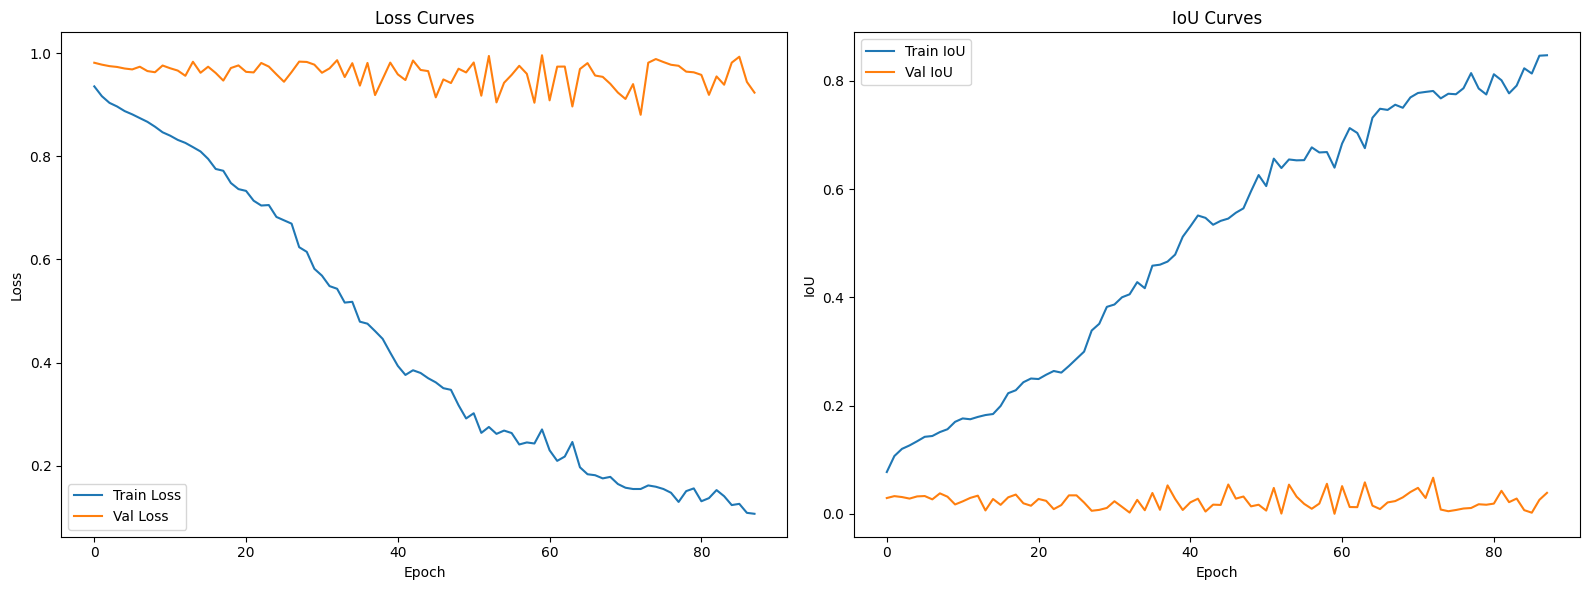

Evaluating on train set...


Evaluating Train: 100%|██████████| 14/14 [00:01<00:00,  9.79it/s]



Train Metrics:
  Average IoU: 0.7712
  Background IoU: 0.9931
  Wetland IoU: 0.7640
  Mean IoU: 0.8785
  Precision: 0.8577
  Recall: 0.8748
  F1 Score: 0.8662
Evaluating on validation set...


Evaluating Val: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]



Val Metrics:
  Average IoU: 0.0670
  Background IoU: 0.9790
  Wetland IoU: 0.0671
  Mean IoU: 0.5231
  Precision: 0.0909
  Recall: 0.2045
  F1 Score: 0.1258
Evaluating on test set...


Evaluating Test: 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]



Test Metrics:
  Average IoU: 0.0500
  Background IoU: 0.9625
  Wetland IoU: 0.0534
  Mean IoU: 0.5080
  Precision: 0.1775
  Recall: 0.0709
  F1 Score: 0.1013
Plotting confusion matrix...


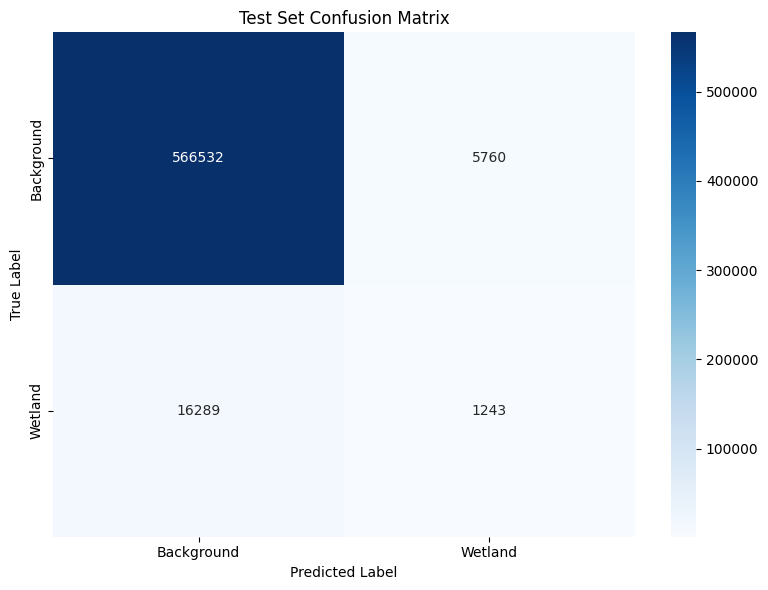

Visualizing train predictions...


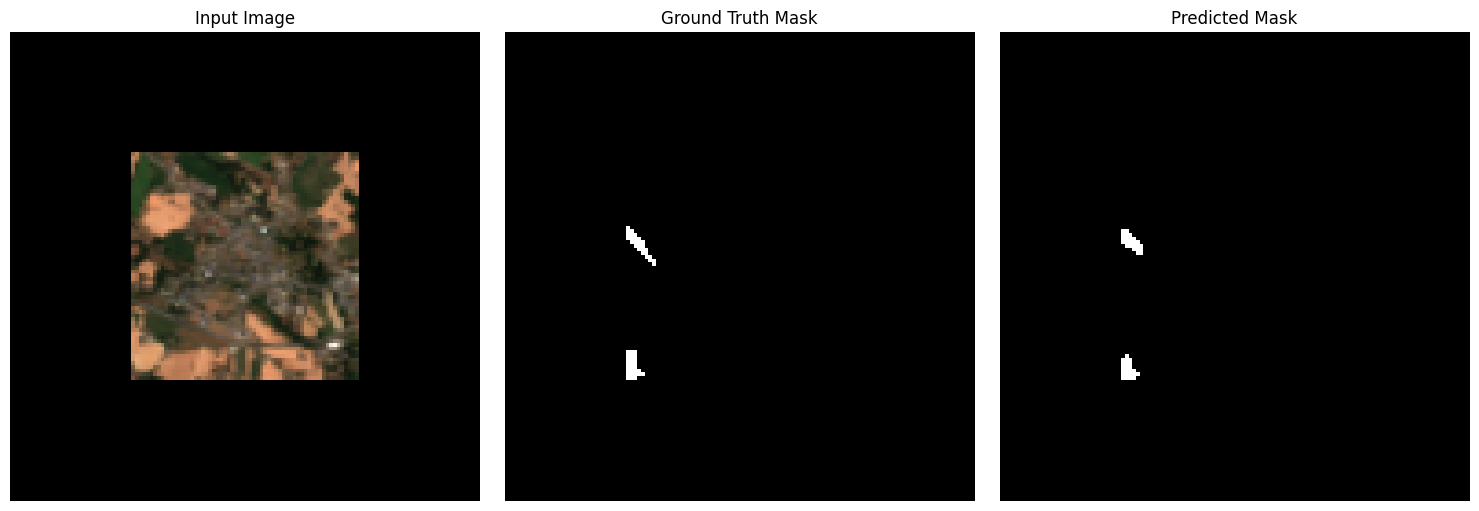

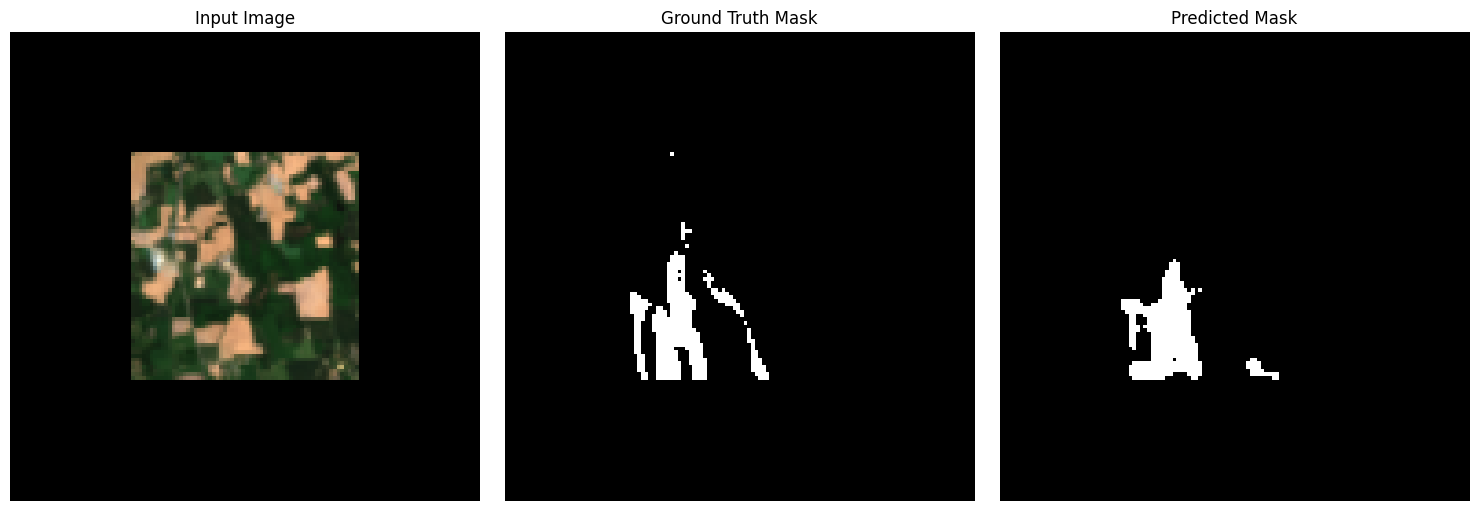

Visualizing test predictions...


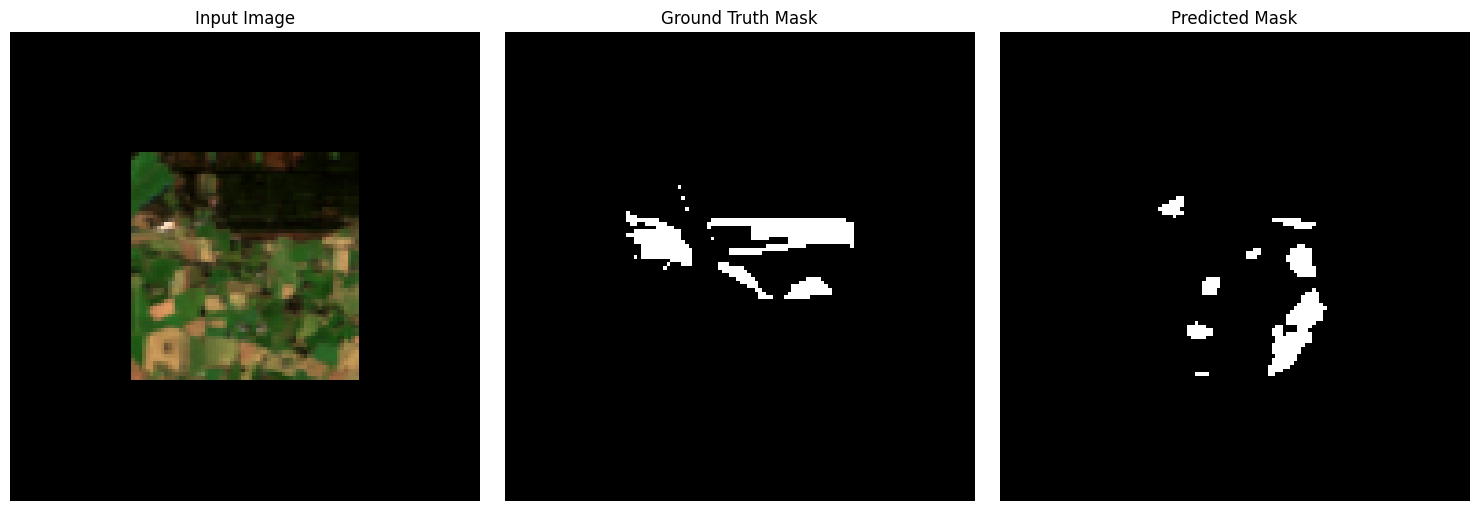

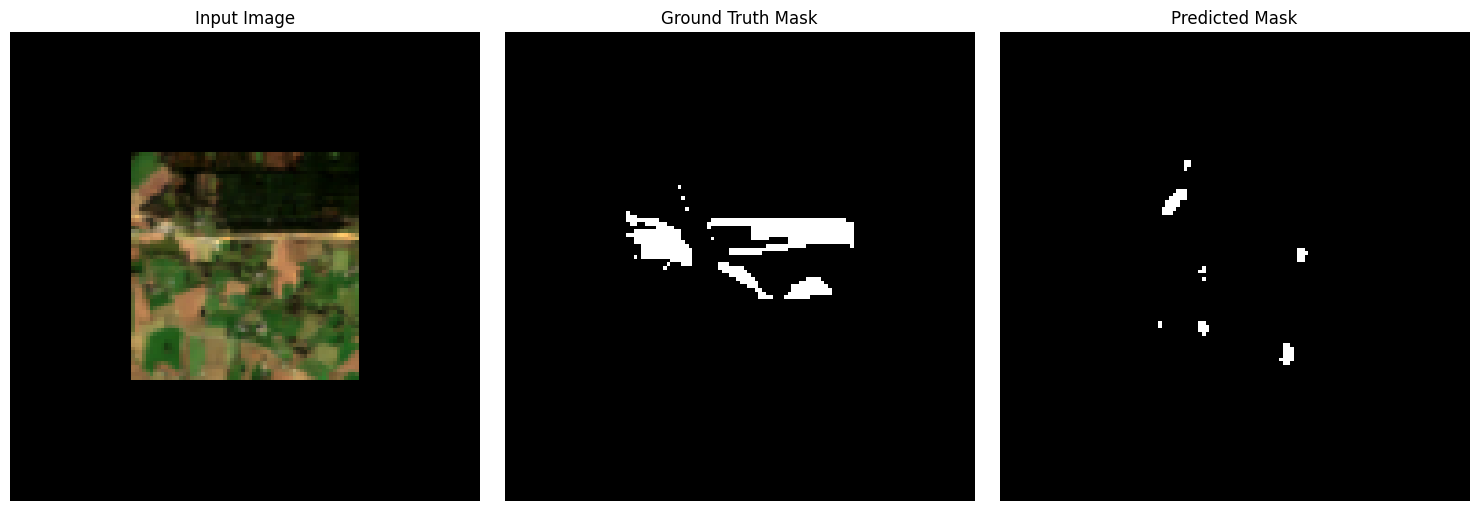

Completed Unet_pretrained!


In [7]:
print("Training the Unet model...")
model_name = "Unet_pretrained"
model, train_losses, val_losses, train_ious, val_ious = train_model(
    model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=15
)
print(model)

# Plot training results
print("Plotting training results...")
plot_results(train_losses, val_losses, train_ious, val_ious)

# Evaluate on all datasets
print("Evaluating on train set...")
train_iou, train_cm, train_bg_iou, train_wetland_iou, train_mean_iou = evaluate_model(model, train_loader, name="Train")

print("Evaluating on validation set...")
val_iou, val_cm, val_bg_iou, val_wetland_iou, val_mean_iou = evaluate_model(model, val_loader, name="Val")  # Fixed: using val_loader here

print("Evaluating on test set...")
test_iou, test_cm, test_bg_iou, test_wetland_iou, test_mean_iou = evaluate_model(model, test_loader, name="Test")

# Update the results dataframe
results_df = track_model_performance(
    results_df, model_name, len(train_losses),
    train_bg_iou, train_wetland_iou, train_mean_iou,
    val_bg_iou, val_wetland_iou, val_mean_iou,
    test_bg_iou, test_wetland_iou, test_mean_iou
)




# Plot confusion matrix and visualize predictions
print("Plotting confusion matrix...")
plot_confusion_matrix(test_cm, title="Test Set Confusion Matrix")

print("Visualizing train predictions...")
visualize_predictions(model, train_loader, num_samples=2)

print("Visualizing test predictions...")
visualize_predictions(model, test_loader, num_samples=2)

print(f"Completed {model_name}!")

**Fine-tuned U-Net Modelling Summary**<br>

**Training Performance Patterns**<br>
The loss and IoU curves (Image 1) show steady improvement in training performance, with training loss decreasing from 0.94 to 0.71 over 27 epochs. Training IoU improves consistently to approximately 0.26, demonstrating gradual learning. However, the validation IoU remains consistently low (below 0.05), indicating a significant generalization gap.

**Classification Performance**<br>
The confusion matrix (Image 2) shows reasonable background classification (489,987 true negatives) but reveals challenges with wetlands. While the model identifies 11,509 true positive wetland pixels, it also produces 82,305 false positives and misses 6,023 wetland pixels. This indicates a tendency toward over-prediction of wetland areas.

**Visual Prediction Analysis**<br>
The prediction visualizations (Images 3-4) confirm the over-segmentation issue. The model generally classifies large portions of images as wetlands rather than precisely delineating wetland boundaries. This approach captures more actual wetland pixels but also incorrectly labels significant non-wetland areas.

**Quantitative Metrics Summary**<br>
The evaluation metrics highlight moderate performance with a clear training-test gap:<br>
- Train set: Mean IoU of 0.52 (Background: 0.88, Wetland: 0.16)
- Validation set: Mean IoU of 0.44 (Background: 0.85, Wetland: 0.03)
- Test set: Mean IoU of 0.48 (Background: 0.85, Wetland: 0.12)

The Mean IoU of 0.48 on the test set represents a marginal improvement over previous approaches. The model achieves better wetland recall (0.66) but suffers from precision issues (0.12) due to over-prediction. This suggests the transfer learning approach has shifted the bias toward wetland classification, but hasn't substantially improved overall segmentation quality as measured by the balanced Mean IoU metric.

## Model Unet transfer learning


**Model Architecture**<br>
This code implements a U-Net architecture with a pre-trained ResNet34 backbone for wetlands segmentation. It employs a transfer learning approach by freezing only the encoder weights while allowing the decoder to be fine-tuned through training.

**Parameter Configuration**<br>
The implementation strategically freezes the encoder parameters to leverage pre-trained ImageNet knowledge while keeping the decoder trainable (12.90% of total parameters). This selective freezing approach balances knowledge transfer with adaptation to the specific wetlands domain.



Using device: cuda
Total parameters: 24436369
Trainable parameters: 3151697
Percentage of trainable parameters: 12.90%
Model setup complete. Ready for training with frozen encoder and trainable decoder.
Training the Unet model with frozen encoder...


Epoch 1/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


Epoch 1/100 - Train Loss: 0.9367, Train IoU: 0.0670, Val Loss: 0.9821, Val IoU: 0.0342
  Model saved!


Epoch 2/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.68it/s]


Epoch 2/100 - Train Loss: 0.9182, Train IoU: 0.0977, Val Loss: 0.9755, Val IoU: 0.0380
  Model saved!


Epoch 3/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


Epoch 3/100 - Train Loss: 0.9071, Train IoU: 0.1062, Val Loss: 0.9730, Val IoU: 0.0317
  Model saved!


Epoch 4/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


Epoch 4/100 - Train Loss: 0.8981, Train IoU: 0.1068, Val Loss: 0.9692, Val IoU: 0.0324
  Model saved!


Epoch 5/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


Epoch 5/100 - Train Loss: 0.8908, Train IoU: 0.1113, Val Loss: 0.9673, Val IoU: 0.0314
  Model saved!


Epoch 6/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


Epoch 6/100 - Train Loss: 0.8825, Train IoU: 0.1184, Val Loss: 0.9655, Val IoU: 0.0322
  Model saved!


Epoch 7/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]


Epoch 7/100 - Train Loss: 0.8735, Train IoU: 0.1232, Val Loss: 0.9672, Val IoU: 0.0312
  Early stopping counter: 1/15


Epoch 8/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


Epoch 8/100 - Train Loss: 0.8688, Train IoU: 0.1275, Val Loss: 0.9626, Val IoU: 0.0328
  Model saved!


Epoch 9/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


Epoch 9/100 - Train Loss: 0.8581, Train IoU: 0.1417, Val Loss: 0.9679, Val IoU: 0.0287
  Early stopping counter: 1/15


Epoch 10/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]


Epoch 10/100 - Train Loss: 0.8555, Train IoU: 0.1343, Val Loss: 0.9636, Val IoU: 0.0286
  Early stopping counter: 2/15


Epoch 11/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


Epoch 11/100 - Train Loss: 0.8460, Train IoU: 0.1489, Val Loss: 0.9649, Val IoU: 0.0302
  Early stopping counter: 3/15


Epoch 12/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


Epoch 12/100 - Train Loss: 0.8405, Train IoU: 0.1515, Val Loss: 0.9649, Val IoU: 0.0278
  Early stopping counter: 4/15


Epoch 13/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


Epoch 13/100 - Train Loss: 0.8331, Train IoU: 0.1581, Val Loss: 0.9608, Val IoU: 0.0305
  Model saved!


Epoch 14/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


Epoch 14/100 - Train Loss: 0.8267, Train IoU: 0.1617, Val Loss: 0.9673, Val IoU: 0.0254
  Early stopping counter: 1/15


Epoch 15/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


Epoch 15/100 - Train Loss: 0.8214, Train IoU: 0.1778, Val Loss: 0.9615, Val IoU: 0.0278
  Early stopping counter: 2/15


Epoch 16/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Epoch 16/100 - Train Loss: 0.8128, Train IoU: 0.1801, Val Loss: 0.9638, Val IoU: 0.0286
  Early stopping counter: 3/15


Epoch 17/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


Epoch 17/100 - Train Loss: 0.8172, Train IoU: 0.1658, Val Loss: 0.9661, Val IoU: 0.0246
  Early stopping counter: 4/15


Epoch 18/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.40it/s]


Epoch 18/100 - Train Loss: 0.7991, Train IoU: 0.1894, Val Loss: 0.9672, Val IoU: 0.0261
  Early stopping counter: 5/15


Epoch 19/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


Epoch 19/100 - Train Loss: 0.7890, Train IoU: 0.1985, Val Loss: 0.9720, Val IoU: 0.0180
  Early stopping counter: 6/15


Epoch 20/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


Epoch 20/100 - Train Loss: 0.7885, Train IoU: 0.2002, Val Loss: 0.9670, Val IoU: 0.0246
  Early stopping counter: 7/15


Epoch 21/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


Epoch 21/100 - Train Loss: 0.7796, Train IoU: 0.2057, Val Loss: 0.9657, Val IoU: 0.0292
  Early stopping counter: 8/15


Epoch 22/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


Epoch 22/100 - Train Loss: 0.7694, Train IoU: 0.2183, Val Loss: 0.9687, Val IoU: 0.0213
  Early stopping counter: 9/15


Epoch 23/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


Epoch 23/100 - Train Loss: 0.7648, Train IoU: 0.2103, Val Loss: 0.9696, Val IoU: 0.0229
  Early stopping counter: 10/15


Epoch 24/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


Epoch 24/100 - Train Loss: 0.7548, Train IoU: 0.2219, Val Loss: 0.9698, Val IoU: 0.0191
  Early stopping counter: 11/15


Epoch 25/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.70it/s]


Epoch 25/100 - Train Loss: 0.7463, Train IoU: 0.2312, Val Loss: 0.9669, Val IoU: 0.0247
  Early stopping counter: 12/15


Epoch 26/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


Epoch 26/100 - Train Loss: 0.7434, Train IoU: 0.2325, Val Loss: 0.9689, Val IoU: 0.0201
  Early stopping counter: 13/15


Epoch 27/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


Epoch 27/100 - Train Loss: 0.7186, Train IoU: 0.2561, Val Loss: 0.9610, Val IoU: 0.0265
  Early stopping counter: 14/15


Epoch 28/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


Epoch 28/100 - Train Loss: 0.7125, Train IoU: 0.2586, Val Loss: 0.9749, Val IoU: 0.0158
  Early stopping counter: 15/15
Early stopping triggered!
Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d

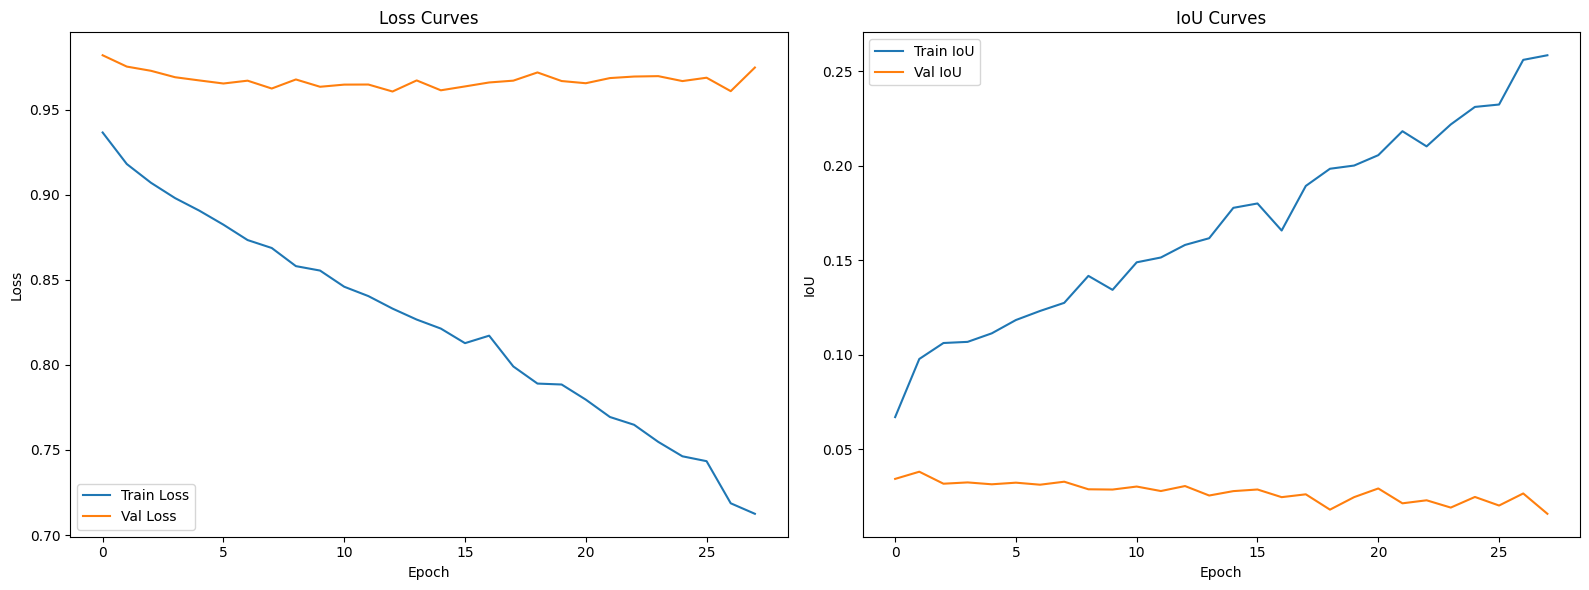

Evaluating on train set...


Evaluating Train: 100%|██████████| 14/14 [00:01<00:00, 10.11it/s]



Train Metrics:
  Average IoU: 0.1609
  Background IoU: 0.8779
  Wetland IoU: 0.1630
  Mean IoU: 0.5205
  Precision: 0.1650
  Recall: 0.9299
  F1 Score: 0.2803
Evaluating on validation set...


Evaluating Val: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s]



Val Metrics:
  Average IoU: 0.0305
  Background IoU: 0.8513
  Wetland IoU: 0.0303
  Mean IoU: 0.4408
  Precision: 0.0309
  Recall: 0.6270
  F1 Score: 0.0589
Evaluating on test set...


Evaluating Test: 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]



Test Metrics:
  Average IoU: 0.1119
  Background IoU: 0.8473
  Wetland IoU: 0.1153
  Mean IoU: 0.4813
  Precision: 0.1227
  Recall: 0.6565
  F1 Score: 0.2067
Plotting confusion matrix...


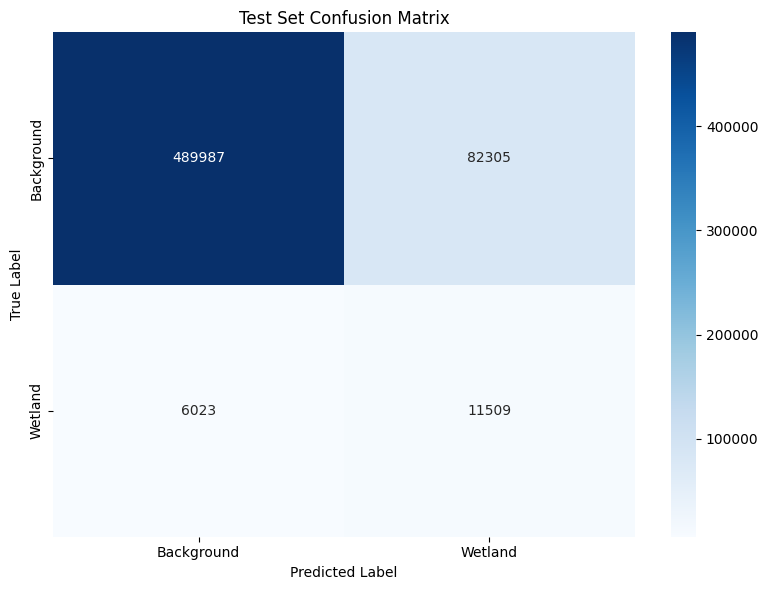

Visualizing train predictions...


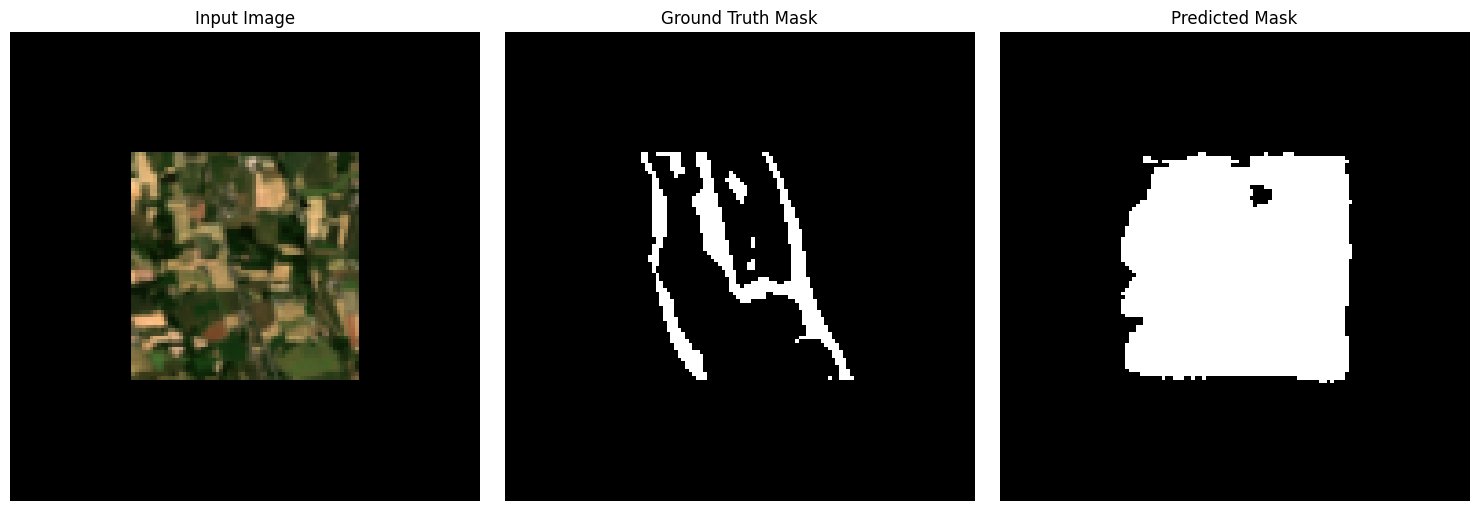

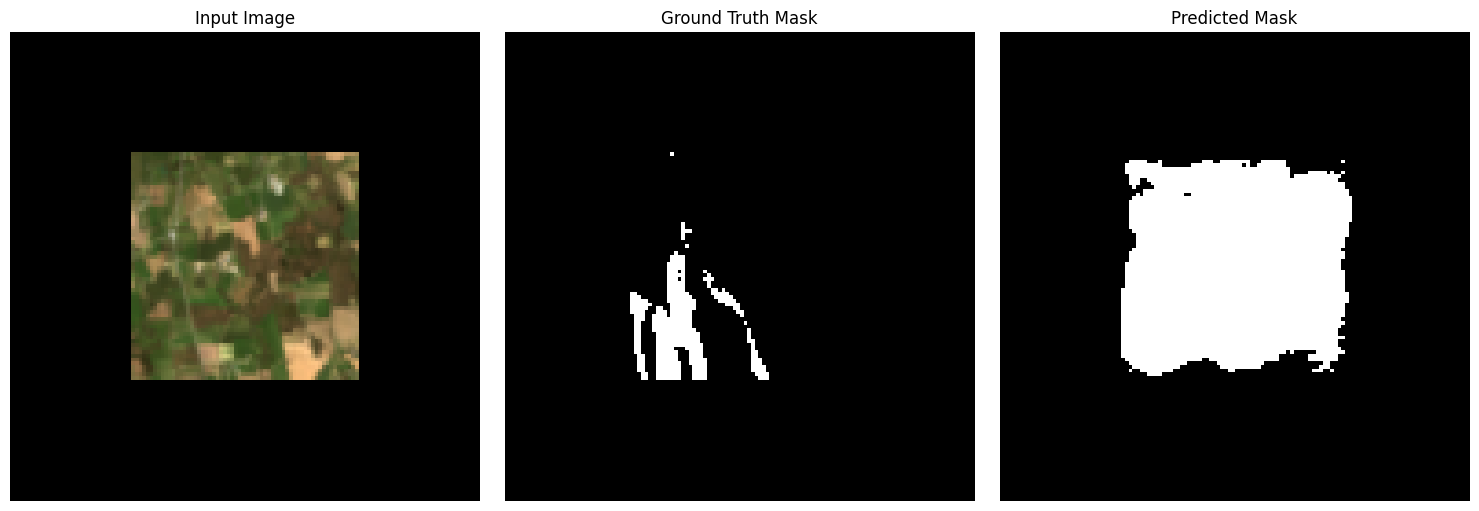

Visualizing test predictions...


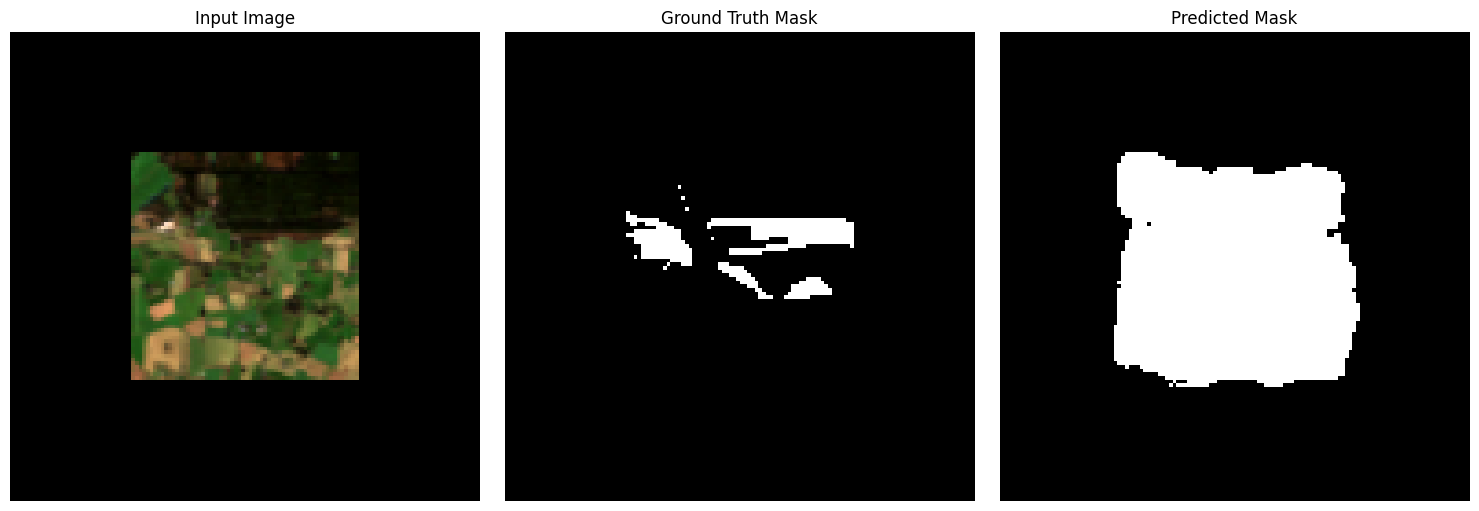

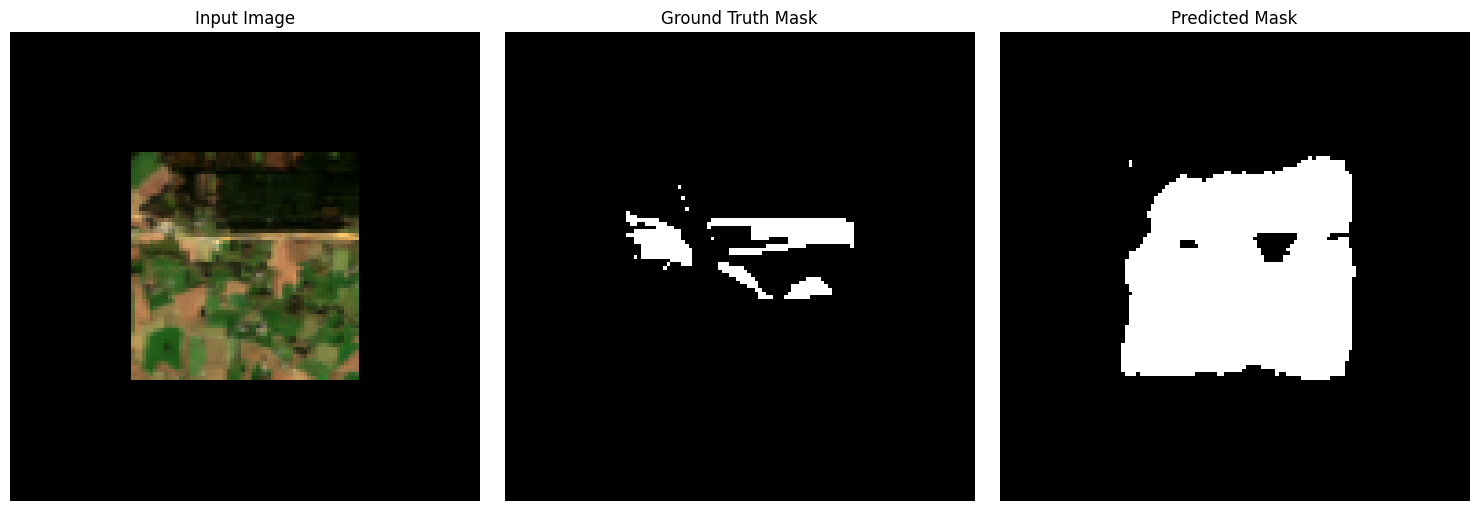

Completed Unet_TL_FrozenEncoder!


In [8]:
# Define the model with transfer learning approach - only freeze encoder
import torch
import segmentation_models_pytorch as smp

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,  # Binary segmentation
)

model = model.to(device)

# Freeze only the encoder
for param in model.encoder.parameters():
    param.requires_grad = False
    
# Keep decoder and segmentation head trainable (don't freeze them)
# This will allow the model to better adapt to your specific data distribution

# Verify parameter freezing
total_params = 0
trainable_params = 0
for param in model.parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

# Define loss function and optimizer (optimizing decoder and segmentation head)
criterion = smp.losses.DiceLoss('binary')
# Filter to only optimize parameters that require gradients
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Now you can train using your existing functions
print("Model setup complete. Ready for training with frozen encoder and trainable decoder.")

# Run your training with:
model_name = "Unet_TL_FrozenEncoder"

# Main execution code
print("Training the Unet model with frozen encoder...")
model, train_losses, val_losses, train_ious, val_ious = train_model(
    model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=15
)
print(model)

# Plot training results
print("Plotting training results...")
plot_results(train_losses, val_losses, train_ious, val_ious)

# Evaluate on all datasets
print("Evaluating on train set...")
train_iou, train_cm, train_bg_iou, train_wetland_iou, train_mean_iou = evaluate_model(model, train_loader, name="Train")

print("Evaluating on validation set...")
val_iou, val_cm, val_bg_iou, val_wetland_iou, val_mean_iou = evaluate_model(model, val_loader, name="Val")

print("Evaluating on test set...")
test_iou, test_cm, test_bg_iou, test_wetland_iou, test_mean_iou = evaluate_model(model, test_loader, name="Test")

# Update the results dataframe
results_df = track_model_performance(
    results_df, model_name, len(train_losses),
    train_bg_iou, train_wetland_iou, train_mean_iou,
    val_bg_iou, val_wetland_iou, val_mean_iou,
    test_bg_iou, test_wetland_iou, test_mean_iou
)

# Plot confusion matrix and visualize predictions
print("Plotting confusion matrix...")
plot_confusion_matrix(test_cm, title="Test Set Confusion Matrix")

print("Visualizing train predictions...")
visualize_predictions(model, train_loader, num_samples=2)

print("Visualizing test predictions...")
visualize_predictions(model, test_loader, num_samples=2)

print(f"Completed {model_name}!")

**Transfer Learning U-Net Modelling Summary**<br>

**Training Performance Patterns**<br>
The loss and IoU curves (Image 1) show gradual improvement in training performance, with training loss decreasing from 0.99 to 0.71 over 26 epochs. Training IoU increases steadily to approximately 0.26, indicating consistent learning on training data. However, the validation IoU remains extremely low throughout (around 0.02), highlighting a substantial gap between training and validation performance.

**Classification Performance**<br>
The confusion matrix (Image 2) demonstrates moderate background classification accuracy (489,987 true negatives) but reveals significant wetland detection challenges. With 11,509 true positive wetland pixels versus 82,305 false positives, the model shows a strong bias toward wetland over-prediction. This explains the high recall but poor precision in wetland identification.

**Visual Prediction Analysis**<br>
The prediction visualizations (Images 3-4) clearly demonstrate the over-segmentation problem. Instead of precisely identifying wetland boundaries, the model classifies almost entire image patches as wetlands. While this approach captures most actual wetland pixels, it severely compromises segmentation accuracy by including substantial non-wetland areas.

**Quantitative Metrics Summary**<br>
The evaluation metrics reveal modest overall performance with consistent generalization issues:<br>
- Train set: Mean IoU of 0.52 (Background: 0.88, Wetland: 0.16)
- Validation set: Mean IoU of 0.44 (Background: 0.85, Wetland: 0.03)
- Test set: Mean IoU of 0.48 (Background: 0.85, Wetland: 0.12)

The Mean IoU of 0.48 on test data represents an improvement over earlier models but remains limited by the precision-recall imbalance. With high recall (0.66) but low precision (0.12), the transfer learning approach has effectively shifted the model bias toward wetland detection at the expense of segmentation accuracy. The background IoU of 0.85 compared to wetland IoU of 0.12 further highlights the class imbalance challenge in this dataset.

# Model Deeplabsv3+

**DeepLabV3+ Model Implementation**<br>

**Model Configuration**<br>
This code implements the DeepLabV3+ architecture using a ResNet34 backbone pre-trained on ImageNet. The model is configured for binary wetland segmentation with RGB input channels and outputs single-channel probability maps.

**Training Setup**<br>
The implementation uses Dice Loss for optimization, which is particularly effective for segmentation tasks with class imbalance. The Adam optimizer with learning rate 1e-4 is employed for parameter updates during training with early stopping patience of 15 epochs to prevent overfitting.

**Evaluation Workflow**<br>
The code establishes a comprehensive evaluation pipeline that calculates performance metrics across training, validation, and test datasets. It tracks class-specific IoU scores for both background and wetland regions, as well as mean IoU for overall performance assessment.

**Results Tracking**<br>
Performance metrics are systematically recorded in a DataFrame for comparative analysis with other models. This structured approach enables clear assessment of the DeepLabV3+ architecture's effectiveness compared to alternate segmentation approaches.

**Visualization Components**<br>
The implementation includes visualization functions for training curves, confusion matrices, and side-by-side prediction comparisons. These visual aids support qualitative evaluation of segmentation results and help identify specific strengths and limitations of the DeepLabV3+ model.

In [9]:
# Define the DeepLabV3+ model
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",  # Using ResNet50 backbone
    encoder_weights="imagenet",  # Pre-trained on ImageNet
    in_channels=3,  # RGB input
    classes=1,  # Binary segmentation (wetland vs background)
)

model = model.to(device)

# Define loss function and optimizer
criterion = smp.losses.DiceLoss('binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



## Modelling Deeplabsv3+ results

Epoch 1/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


Epoch 1/100 - Train Loss: 0.9353, Train IoU: 0.0763, Val Loss: 0.9850, Val IoU: 0.0000
  Model saved!


Epoch 2/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 2/100 - Train Loss: 0.9035, Train IoU: 0.0936, Val Loss: 0.9774, Val IoU: 0.0560
  Model saved!


Epoch 3/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


Epoch 3/100 - Train Loss: 0.8869, Train IoU: 0.0948, Val Loss: 0.9631, Val IoU: 0.0298
  Model saved!


Epoch 4/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


Epoch 4/100 - Train Loss: 0.8630, Train IoU: 0.1178, Val Loss: 0.9592, Val IoU: 0.0317
  Model saved!


Epoch 5/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


Epoch 5/100 - Train Loss: 0.8500, Train IoU: 0.1231, Val Loss: 0.9553, Val IoU: 0.0326
  Model saved!


Epoch 6/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]


Epoch 6/100 - Train Loss: 0.8403, Train IoU: 0.1279, Val Loss: 0.9492, Val IoU: 0.0349
  Model saved!


Epoch 7/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]


Epoch 7/100 - Train Loss: 0.8336, Train IoU: 0.1324, Val Loss: 0.9610, Val IoU: 0.0333
  Early stopping counter: 1/15


Epoch 8/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


Epoch 8/100 - Train Loss: 0.8146, Train IoU: 0.1484, Val Loss: 0.9453, Val IoU: 0.0361
  Model saved!


Epoch 9/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


Epoch 9/100 - Train Loss: 0.8113, Train IoU: 0.1454, Val Loss: 0.9711, Val IoU: 0.0193
  Early stopping counter: 1/15


Epoch 10/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


Epoch 10/100 - Train Loss: 0.7997, Train IoU: 0.1550, Val Loss: 0.9404, Val IoU: 0.0402
  Model saved!


Epoch 11/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]


Epoch 11/100 - Train Loss: 0.7917, Train IoU: 0.1555, Val Loss: 0.9447, Val IoU: 0.0381
  Early stopping counter: 1/15


Epoch 12/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


Epoch 12/100 - Train Loss: 0.7777, Train IoU: 0.1701, Val Loss: 0.9365, Val IoU: 0.0399
  Model saved!


Epoch 13/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


Epoch 13/100 - Train Loss: 0.7674, Train IoU: 0.1682, Val Loss: 0.9343, Val IoU: 0.0458
  Model saved!


Epoch 14/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]


Epoch 14/100 - Train Loss: 0.7580, Train IoU: 0.1826, Val Loss: 0.9416, Val IoU: 0.0346
  Early stopping counter: 1/15


Epoch 15/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


Epoch 15/100 - Train Loss: 0.7447, Train IoU: 0.1853, Val Loss: 0.9406, Val IoU: 0.0349
  Early stopping counter: 2/15


Epoch 16/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]


Epoch 16/100 - Train Loss: 0.7198, Train IoU: 0.2111, Val Loss: 0.9409, Val IoU: 0.0361
  Early stopping counter: 3/15


Epoch 17/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


Epoch 17/100 - Train Loss: 0.7166, Train IoU: 0.2054, Val Loss: 0.9363, Val IoU: 0.0379
  Early stopping counter: 4/15


Epoch 18/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


Epoch 18/100 - Train Loss: 0.7022, Train IoU: 0.2225, Val Loss: 0.9266, Val IoU: 0.0489
  Model saved!


Epoch 19/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


Epoch 19/100 - Train Loss: 0.6854, Train IoU: 0.2318, Val Loss: 0.9503, Val IoU: 0.0293
  Early stopping counter: 1/15


Epoch 20/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


Epoch 20/100 - Train Loss: 0.6774, Train IoU: 0.2380, Val Loss: 0.9592, Val IoU: 0.0213
  Early stopping counter: 2/15


Epoch 21/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


Epoch 21/100 - Train Loss: 0.6703, Train IoU: 0.2458, Val Loss: 0.9556, Val IoU: 0.0258
  Early stopping counter: 3/15


Epoch 22/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


Epoch 22/100 - Train Loss: 0.6461, Train IoU: 0.2626, Val Loss: 0.9409, Val IoU: 0.0401
  Early stopping counter: 4/15


Epoch 23/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


Epoch 23/100 - Train Loss: 0.6576, Train IoU: 0.2468, Val Loss: 0.9608, Val IoU: 0.0195
  Early stopping counter: 5/15


Epoch 24/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]


Epoch 24/100 - Train Loss: 0.6451, Train IoU: 0.2525, Val Loss: 0.9197, Val IoU: 0.0468
  Model saved!


Epoch 25/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


Epoch 25/100 - Train Loss: 0.6341, Train IoU: 0.2690, Val Loss: 0.9372, Val IoU: 0.0353
  Early stopping counter: 1/15


Epoch 26/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


Epoch 26/100 - Train Loss: 0.6365, Train IoU: 0.2555, Val Loss: 0.9287, Val IoU: 0.0408
  Early stopping counter: 2/15


Epoch 27/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


Epoch 27/100 - Train Loss: 0.5999, Train IoU: 0.2862, Val Loss: 0.9347, Val IoU: 0.0365
  Early stopping counter: 3/15


Epoch 28/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.23it/s]


Epoch 28/100 - Train Loss: 0.5880, Train IoU: 0.2933, Val Loss: 0.9351, Val IoU: 0.0340
  Early stopping counter: 4/15


Epoch 29/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


Epoch 29/100 - Train Loss: 0.5870, Train IoU: 0.2959, Val Loss: 0.9508, Val IoU: 0.0259
  Early stopping counter: 5/15


Epoch 30/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


Epoch 30/100 - Train Loss: 0.5704, Train IoU: 0.3065, Val Loss: 0.9778, Val IoU: 0.0073
  Early stopping counter: 6/15


Epoch 31/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Epoch 31/100 - Train Loss: 0.5593, Train IoU: 0.3205, Val Loss: 0.9109, Val IoU: 0.0517
  Model saved!


Epoch 32/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]


Epoch 32/100 - Train Loss: 0.5515, Train IoU: 0.3233, Val Loss: 0.9494, Val IoU: 0.0248
  Early stopping counter: 1/15


Epoch 33/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.31it/s]


Epoch 33/100 - Train Loss: 0.5397, Train IoU: 0.3343, Val Loss: 0.9152, Val IoU: 0.0466
  Early stopping counter: 2/15


Epoch 34/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


Epoch 34/100 - Train Loss: 0.5429, Train IoU: 0.3316, Val Loss: 0.9143, Val IoU: 0.0448
  Early stopping counter: 3/15


Epoch 35/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


Epoch 35/100 - Train Loss: 0.5424, Train IoU: 0.3271, Val Loss: 0.8950, Val IoU: 0.0638
  Model saved!


Epoch 36/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


Epoch 36/100 - Train Loss: 0.5361, Train IoU: 0.3341, Val Loss: 0.9692, Val IoU: 0.0086
  Early stopping counter: 1/15


Epoch 37/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


Epoch 37/100 - Train Loss: 0.5352, Train IoU: 0.3360, Val Loss: 0.9154, Val IoU: 0.0441
  Early stopping counter: 2/15


Epoch 38/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]


Epoch 38/100 - Train Loss: 0.5158, Train IoU: 0.3503, Val Loss: 0.9172, Val IoU: 0.0451
  Early stopping counter: 3/15


Epoch 39/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


Epoch 39/100 - Train Loss: 0.5088, Train IoU: 0.3586, Val Loss: 0.9411, Val IoU: 0.0285
  Early stopping counter: 4/15


Epoch 40/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


Epoch 40/100 - Train Loss: 0.5039, Train IoU: 0.3614, Val Loss: 0.9793, Val IoU: 0.0038
  Early stopping counter: 5/15


Epoch 41/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


Epoch 41/100 - Train Loss: 0.5096, Train IoU: 0.3515, Val Loss: 0.8975, Val IoU: 0.0597
  Early stopping counter: 6/15


Epoch 42/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


Epoch 42/100 - Train Loss: 0.4816, Train IoU: 0.3807, Val Loss: 0.9196, Val IoU: 0.0346
  Early stopping counter: 7/15


Epoch 43/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


Epoch 43/100 - Train Loss: 0.4834, Train IoU: 0.3775, Val Loss: 0.9023, Val IoU: 0.0514
  Early stopping counter: 8/15


Epoch 44/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


Epoch 44/100 - Train Loss: 0.4649, Train IoU: 0.3945, Val Loss: 0.8591, Val IoU: 0.0860
  Model saved!


Epoch 45/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


Epoch 45/100 - Train Loss: 0.4607, Train IoU: 0.3989, Val Loss: 0.8657, Val IoU: 0.0779
  Early stopping counter: 1/15


Epoch 46/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


Epoch 46/100 - Train Loss: 0.4723, Train IoU: 0.3870, Val Loss: 0.8892, Val IoU: 0.0641
  Early stopping counter: 2/15


Epoch 47/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


Epoch 47/100 - Train Loss: 0.4907, Train IoU: 0.3717, Val Loss: 0.9737, Val IoU: 0.0053
  Early stopping counter: 3/15


Epoch 48/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


Epoch 48/100 - Train Loss: 0.4571, Train IoU: 0.3987, Val Loss: 0.8951, Val IoU: 0.0574
  Early stopping counter: 4/15


Epoch 49/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.12it/s]


Epoch 49/100 - Train Loss: 0.4686, Train IoU: 0.3876, Val Loss: 0.8913, Val IoU: 0.0621
  Early stopping counter: 5/15


Epoch 50/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


Epoch 50/100 - Train Loss: 0.4442, Train IoU: 0.4106, Val Loss: 0.9015, Val IoU: 0.0546
  Early stopping counter: 6/15


Epoch 51/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


Epoch 51/100 - Train Loss: 0.4489, Train IoU: 0.4052, Val Loss: 0.9009, Val IoU: 0.0516
  Early stopping counter: 7/15


Epoch 52/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


Epoch 52/100 - Train Loss: 0.4444, Train IoU: 0.4107, Val Loss: 0.8726, Val IoU: 0.0747
  Early stopping counter: 8/15


Epoch 53/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


Epoch 53/100 - Train Loss: 0.4356, Train IoU: 0.4203, Val Loss: 0.8540, Val IoU: 0.0845
  Model saved!


Epoch 54/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


Epoch 54/100 - Train Loss: 0.4274, Train IoU: 0.4305, Val Loss: 0.9383, Val IoU: 0.0244
  Early stopping counter: 1/15


Epoch 55/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


Epoch 55/100 - Train Loss: 0.4314, Train IoU: 0.4222, Val Loss: 0.8994, Val IoU: 0.0526
  Early stopping counter: 2/15


Epoch 56/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


Epoch 56/100 - Train Loss: 0.4449, Train IoU: 0.4094, Val Loss: 0.9339, Val IoU: 0.0255
  Early stopping counter: 3/15


Epoch 57/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]


Epoch 57/100 - Train Loss: 0.4312, Train IoU: 0.4244, Val Loss: 0.8999, Val IoU: 0.0452
  Early stopping counter: 4/15


Epoch 58/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]


Epoch 58/100 - Train Loss: 0.4373, Train IoU: 0.4173, Val Loss: 0.8746, Val IoU: 0.0707
  Early stopping counter: 5/15


Epoch 59/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


Epoch 59/100 - Train Loss: 0.4201, Train IoU: 0.4344, Val Loss: 0.8965, Val IoU: 0.0568
  Early stopping counter: 6/15


Epoch 60/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


Epoch 60/100 - Train Loss: 0.4189, Train IoU: 0.4355, Val Loss: 0.9155, Val IoU: 0.0430
  Early stopping counter: 7/15


Epoch 61/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]


Epoch 61/100 - Train Loss: 0.4197, Train IoU: 0.4313, Val Loss: 0.8865, Val IoU: 0.0650
  Early stopping counter: 8/15


Epoch 62/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


Epoch 62/100 - Train Loss: 0.4082, Train IoU: 0.4484, Val Loss: 0.8923, Val IoU: 0.0594
  Early stopping counter: 9/15


Epoch 63/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.32it/s]


Epoch 63/100 - Train Loss: 0.4095, Train IoU: 0.4435, Val Loss: 0.9398, Val IoU: 0.0262
  Early stopping counter: 10/15


Epoch 64/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]


Epoch 64/100 - Train Loss: 0.4030, Train IoU: 0.4548, Val Loss: 0.9649, Val IoU: 0.0138
  Early stopping counter: 11/15


Epoch 65/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]


Epoch 65/100 - Train Loss: 0.4313, Train IoU: 0.4243, Val Loss: 0.8760, Val IoU: 0.0720
  Early stopping counter: 12/15


Epoch 66/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


Epoch 66/100 - Train Loss: 0.4111, Train IoU: 0.4410, Val Loss: 0.8812, Val IoU: 0.0700
  Early stopping counter: 13/15


Epoch 67/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]


Epoch 67/100 - Train Loss: 0.3947, Train IoU: 0.4585, Val Loss: 0.8847, Val IoU: 0.0652
  Early stopping counter: 14/15


Epoch 68/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


Epoch 68/100 - Train Loss: 0.3854, Train IoU: 0.4691, Val Loss: 0.8643, Val IoU: 0.0809
  Early stopping counter: 15/15
Early stopping triggered!
DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1

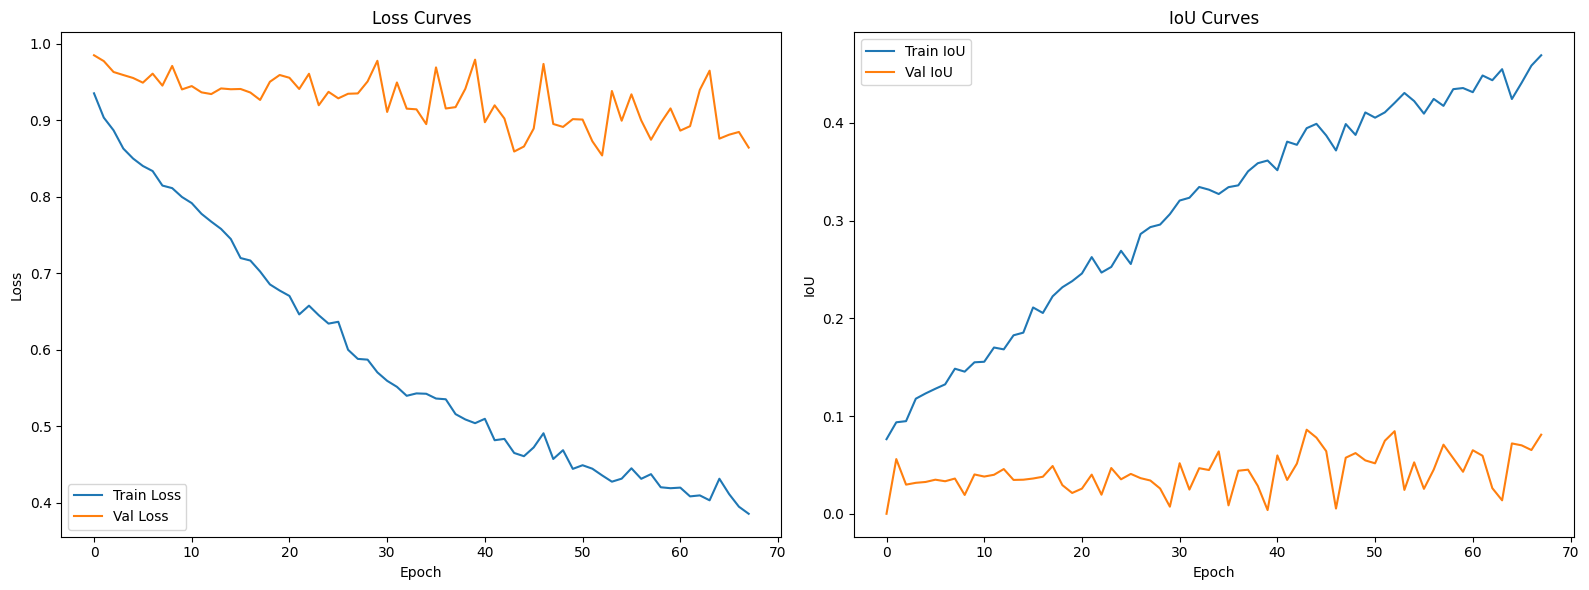

Evaluating on train set...


Evaluating Train: 100%|██████████| 14/14 [00:01<00:00, 10.05it/s]



Train Metrics:
  Average IoU: 0.4231
  Background IoU: 0.9780
  Wetland IoU: 0.4260
  Mean IoU: 0.7020
  Precision: 0.5581
  Recall: 0.6428
  F1 Score: 0.5975
Evaluating on validation set...


Evaluating Val: 100%|██████████| 5/5 [00:00<00:00,  8.97it/s]



Val Metrics:
  Average IoU: 0.0845
  Background IoU: 0.9749
  Wetland IoU: 0.0829
  Mean IoU: 0.5289
  Precision: 0.1020
  Recall: 0.3060
  F1 Score: 0.1530
Evaluating on test set...


Evaluating Test: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]



Test Metrics:
  Average IoU: 0.1042
  Background IoU: 0.9540
  Wetland IoU: 0.1002
  Mean IoU: 0.5271
  Precision: 0.1940
  Recall: 0.1716
  F1 Score: 0.1821
Plotting confusion matrix...


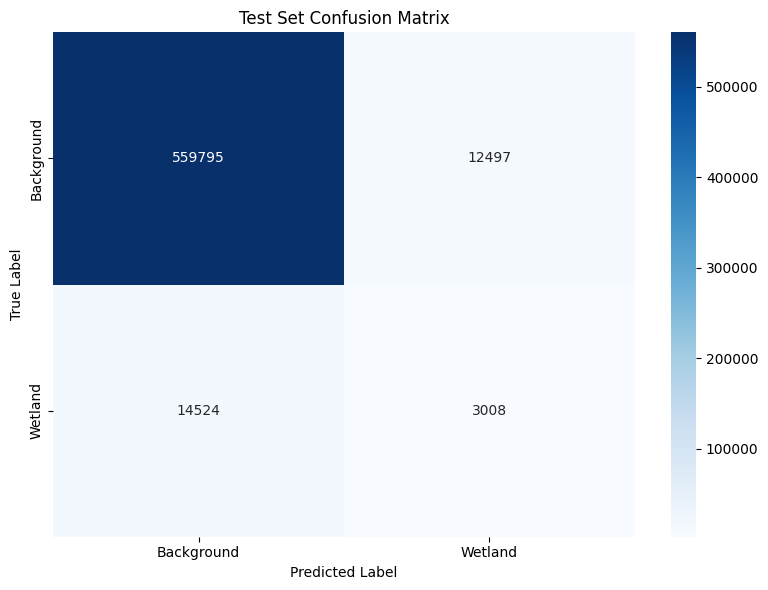

Visualizing train predictions...


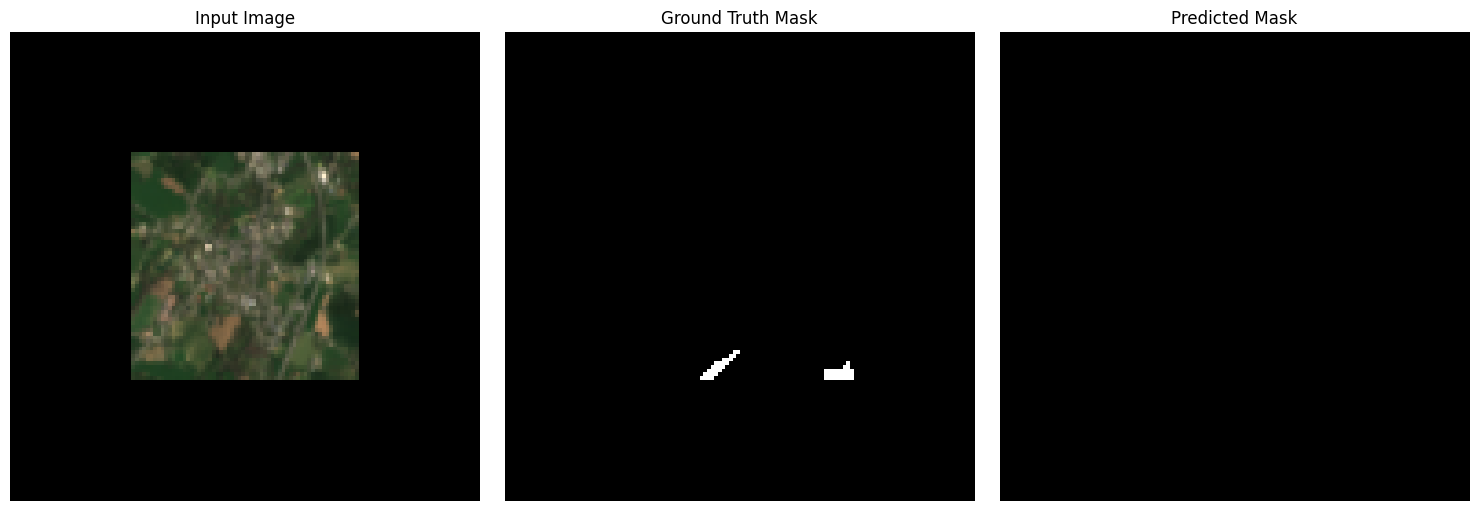

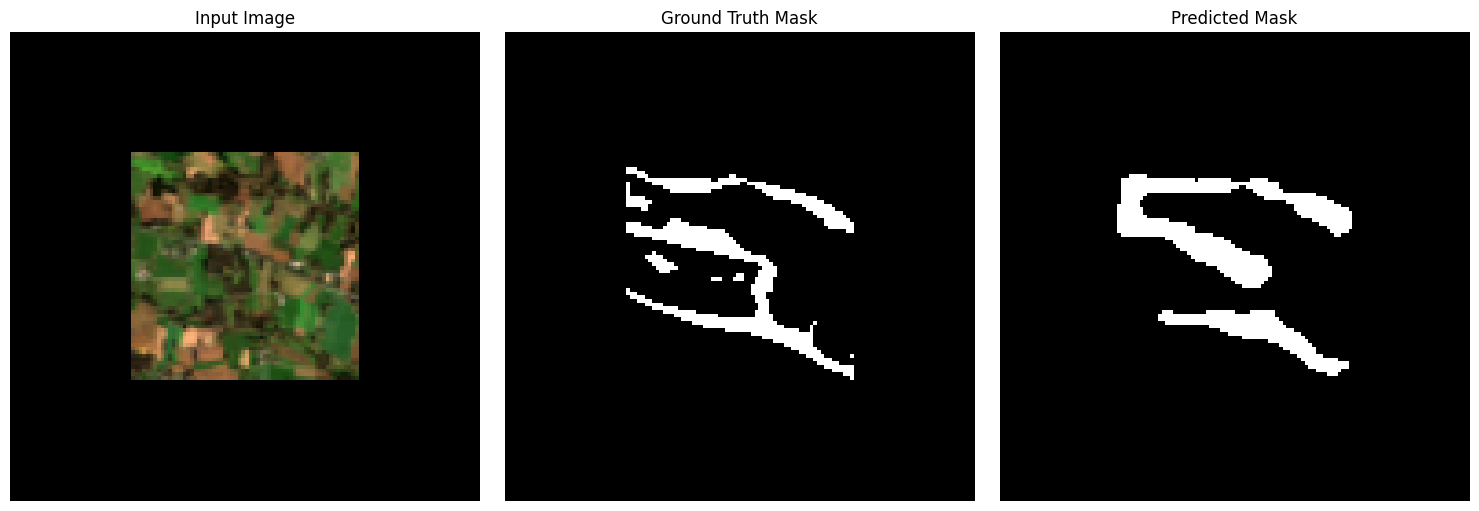

Visualizing test predictions...


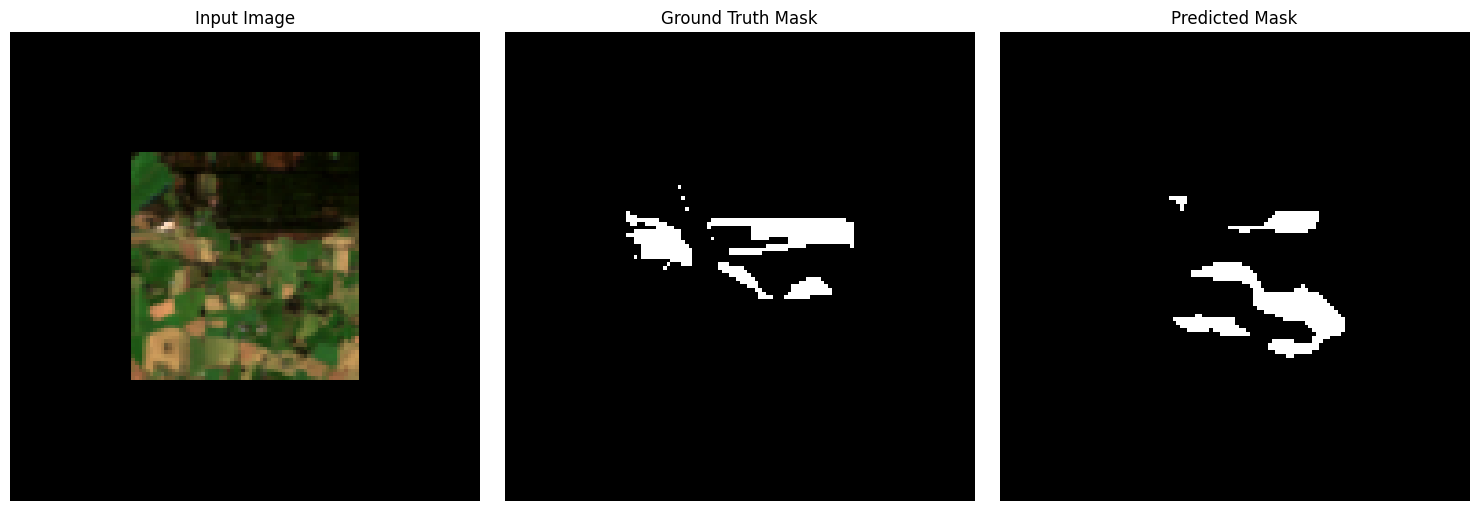

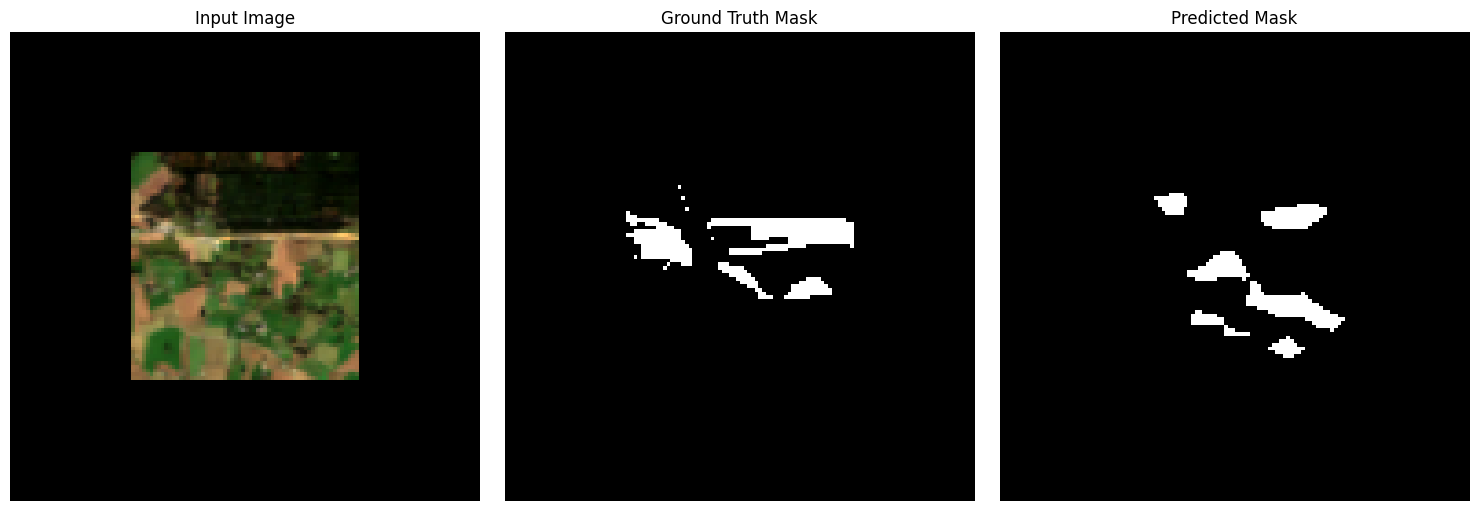

Completed DeepLabV3plus_pretrained!


In [10]:
model_name = "DeepLabV3plus_pretrained"
model, train_losses, val_losses, train_ious, val_ious = train_model(
    model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=15
)
print(model)

# Plot training results
print("Plotting training results...")
plot_results(train_losses, val_losses, train_ious, val_ious)

# Evaluate on all datasets
print("Evaluating on train set...")
train_iou, train_cm, train_bg_iou, train_wetland_iou, train_mean_iou = evaluate_model(model, train_loader, name="Train")

print("Evaluating on validation set...")
val_iou, val_cm, val_bg_iou, val_wetland_iou, val_mean_iou = evaluate_model(model, val_loader, name="Val")  # Fixed: using val_loader here

print("Evaluating on test set...")
test_iou, test_cm, test_bg_iou, test_wetland_iou, test_mean_iou = evaluate_model(model, test_loader, name="Test")

# Update the results dataframe
results_df = track_model_performance(
    results_df, model_name, len(train_losses),
    train_bg_iou, train_wetland_iou, train_mean_iou,
    val_bg_iou, val_wetland_iou, val_mean_iou,
    test_bg_iou, test_wetland_iou, test_mean_iou
)

# Plot confusion matrix and visualize predictions
print("Plotting confusion matrix...")
plot_confusion_matrix(test_cm, title="Test Set Confusion Matrix")

print("Visualizing train predictions...")
visualize_predictions(model, train_loader, num_samples=2)

print("Visualizing test predictions...")
visualize_predictions(model, test_loader, num_samples=2)

print(f"Completed {model_name}!")



**DeepLabV3+ Finetuned Modelling Summary**<br>

**Training Performance Patterns**<br>
The loss and IoU curves (Image 1) demonstrate steady improvement in training performance, with training loss decreasing from 0.93 to 0.39 over 67 epochs. Training IoU increases consistently to approximately 0.47, showing effective learning. The validation loss shows gradual improvement from 0.98 to 0.87, while validation IoU remains low but with slight improvements (up to 0.07), indicating a persistent but smaller generalization gap compared to previous models.

**Classification Performance**<br>
The confusion matrix (Image 2) reveals improved balance in classification performance. With 559,795 true negative background pixels and 3,008 true positive wetland pixels, the model shows better discrimination. While 14,524 wetland pixels are missed (false negatives) and 12,497 background pixels are misclassified as wetlands (false positives), this represents a more balanced error distribution than previous approaches.

**Visual Prediction Analysis**<br>
The prediction visualizations (Images 3-4) demonstrate significantly improved segmentation quality. Unlike previous models that either under- or over-predicted wetlands, DeepLabV3+ shows more precise boundary delineation, especially visible in the second training example. Test predictions capture the general shape and location of wetland features without excessive over-segmentation.

**Quantitative Metrics Summary**<br>
The evaluation metrics confirm substantial improvements in overall performance:<br>
- Train set: Mean IoU of 0.70 (Background: 0.98, Wetland: 0.43)
- Validation set: Mean IoU of 0.53 (Background: 0.97, Wetland: 0.08)
- Test set: Mean IoU of 0.53 (Background: 0.95, Wetland: 0.10)

The Mean IoU of 0.53 on the test set represents the best performance across models evaluated. With more balanced precision (0.19) and recall (0.17) metrics, DeepLabV3+ achieves better overall segmentation quality. The model effectively balances between background and wetland class identification, demonstrating superior generalization compared to previous approaches while maintaining strong background segmentation performance.

## Deeplabv3+ transfer learning


**Model Architecture**<br>
This code implements DeepLabV3+ architecture with a ResNet34 backbone pre-trained on ImageNet. The model is configured for binary wetlands segmentation using RGB input channels and outputs single-channel probability maps.

**Transfer Learning Strategy**<br>
The implementation employs a selective parameter freezing approach that preserves the pre-trained encoder's knowledge while allowing adaptation in the decoder. Only 5.14% of parameters (1,152,785 out of 22,437,457) remain trainable, focusing fine-tuning efforts on task-specific components.

**Parameter Management**<br>
The code includes parameter freezing logic that prevents updates to the encoder weights during backpropagation. This maintains the robust feature extraction capabilities from ImageNet pre-training while allowing the decoder to adapt to wetland-specific patterns.


Using device: cuda
Total parameters: 22437457
Trainable parameters: 1152785
Percentage of trainable parameters: 5.14%
Model setup complete. Ready for training with frozen encoder.


Epoch 1/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


Epoch 1/100 - Train Loss: 0.9461, Train IoU: 0.0560, Val Loss: 0.9851, Val IoU: 0.0000
  Model saved!


Epoch 2/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


Epoch 2/100 - Train Loss: 0.9221, Train IoU: 0.0907, Val Loss: 0.9813, Val IoU: 0.0071
  Model saved!


Epoch 3/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


Epoch 3/100 - Train Loss: 0.9073, Train IoU: 0.0816, Val Loss: 0.9704, Val IoU: 0.0349
  Model saved!


Epoch 4/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


Epoch 4/100 - Train Loss: 0.8955, Train IoU: 0.0842, Val Loss: 0.9630, Val IoU: 0.0308
  Model saved!


Epoch 5/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]


Epoch 5/100 - Train Loss: 0.8869, Train IoU: 0.0875, Val Loss: 0.9574, Val IoU: 0.0316
  Model saved!


Epoch 6/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


Epoch 6/100 - Train Loss: 0.8755, Train IoU: 0.0949, Val Loss: 0.9542, Val IoU: 0.0336
  Model saved!


Epoch 7/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]


Epoch 7/100 - Train Loss: 0.8674, Train IoU: 0.1037, Val Loss: 0.9563, Val IoU: 0.0306
  Early stopping counter: 1/15


Epoch 8/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


Epoch 8/100 - Train Loss: 0.8581, Train IoU: 0.1118, Val Loss: 0.9524, Val IoU: 0.0353
  Model saved!


Epoch 9/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


Epoch 9/100 - Train Loss: 0.8471, Train IoU: 0.1223, Val Loss: 0.9536, Val IoU: 0.0334
  Early stopping counter: 1/15


Epoch 10/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]


Epoch 10/100 - Train Loss: 0.8374, Train IoU: 0.1297, Val Loss: 0.9521, Val IoU: 0.0339
  Model saved!


Epoch 11/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


Epoch 11/100 - Train Loss: 0.8273, Train IoU: 0.1396, Val Loss: 0.9522, Val IoU: 0.0349
  Early stopping counter: 1/15


Epoch 12/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


Epoch 12/100 - Train Loss: 0.8212, Train IoU: 0.1406, Val Loss: 0.9518, Val IoU: 0.0325
  Model saved!


Epoch 13/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


Epoch 13/100 - Train Loss: 0.8102, Train IoU: 0.1423, Val Loss: 0.9510, Val IoU: 0.0327
  Model saved!


Epoch 14/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]


Epoch 14/100 - Train Loss: 0.7977, Train IoU: 0.1517, Val Loss: 0.9494, Val IoU: 0.0338
  Model saved!


Epoch 15/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


Epoch 15/100 - Train Loss: 0.7890, Train IoU: 0.1574, Val Loss: 0.9483, Val IoU: 0.0317
  Model saved!


Epoch 16/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


Epoch 16/100 - Train Loss: 0.7832, Train IoU: 0.1589, Val Loss: 0.9493, Val IoU: 0.0336
  Early stopping counter: 1/15


Epoch 17/100 - Validation: 100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch 17/100 - Train Loss: 0.7793, Train IoU: 0.1611, Val Loss: 0.9510, Val IoU: 0.0287
  Early stopping counter: 2/15


Epoch 18/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


Epoch 18/100 - Train Loss: 0.7730, Train IoU: 0.1623, Val Loss: 0.9476, Val IoU: 0.0314
  Model saved!


Epoch 19/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


Epoch 19/100 - Train Loss: 0.7598, Train IoU: 0.1722, Val Loss: 0.9522, Val IoU: 0.0251
  Early stopping counter: 1/15


Epoch 20/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


Epoch 20/100 - Train Loss: 0.7597, Train IoU: 0.1724, Val Loss: 0.9497, Val IoU: 0.0326
  Early stopping counter: 2/15


Epoch 21/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


Epoch 21/100 - Train Loss: 0.7608, Train IoU: 0.1687, Val Loss: 0.9510, Val IoU: 0.0329
  Early stopping counter: 3/15


Epoch 22/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]


Epoch 22/100 - Train Loss: 0.7384, Train IoU: 0.1892, Val Loss: 0.9506, Val IoU: 0.0290
  Early stopping counter: 4/15


Epoch 23/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


Epoch 23/100 - Train Loss: 0.7367, Train IoU: 0.1834, Val Loss: 0.9483, Val IoU: 0.0253
  Early stopping counter: 5/15


Epoch 24/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


Epoch 24/100 - Train Loss: 0.7354, Train IoU: 0.1842, Val Loss: 0.9510, Val IoU: 0.0233
  Early stopping counter: 6/15


Epoch 25/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


Epoch 25/100 - Train Loss: 0.7211, Train IoU: 0.2015, Val Loss: 0.9510, Val IoU: 0.0273
  Early stopping counter: 7/15


Epoch 26/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


Epoch 26/100 - Train Loss: 0.7173, Train IoU: 0.2014, Val Loss: 0.9512, Val IoU: 0.0275
  Early stopping counter: 8/15


Epoch 27/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


Epoch 27/100 - Train Loss: 0.7129, Train IoU: 0.2062, Val Loss: 0.9664, Val IoU: 0.0138
  Early stopping counter: 9/15


Epoch 28/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 28/100 - Train Loss: 0.7042, Train IoU: 0.2087, Val Loss: 0.9510, Val IoU: 0.0246
  Early stopping counter: 10/15


Epoch 29/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


Epoch 29/100 - Train Loss: 0.6889, Train IoU: 0.2223, Val Loss: 0.9556, Val IoU: 0.0182
  Early stopping counter: 11/15


Epoch 30/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]


Epoch 30/100 - Train Loss: 0.6941, Train IoU: 0.2187, Val Loss: 0.9500, Val IoU: 0.0254
  Early stopping counter: 12/15


Epoch 31/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]


Epoch 31/100 - Train Loss: 0.7044, Train IoU: 0.2063, Val Loss: 0.9547, Val IoU: 0.0226
  Early stopping counter: 13/15


Epoch 32/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


Epoch 32/100 - Train Loss: 0.6992, Train IoU: 0.2117, Val Loss: 0.9505, Val IoU: 0.0251
  Early stopping counter: 14/15


Epoch 33/100 - Validation: 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


Epoch 33/100 - Train Loss: 0.6981, Train IoU: 0.2092, Val Loss: 0.9499, Val IoU: 0.0243
  Early stopping counter: 15/15
Early stopping triggered!
DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1

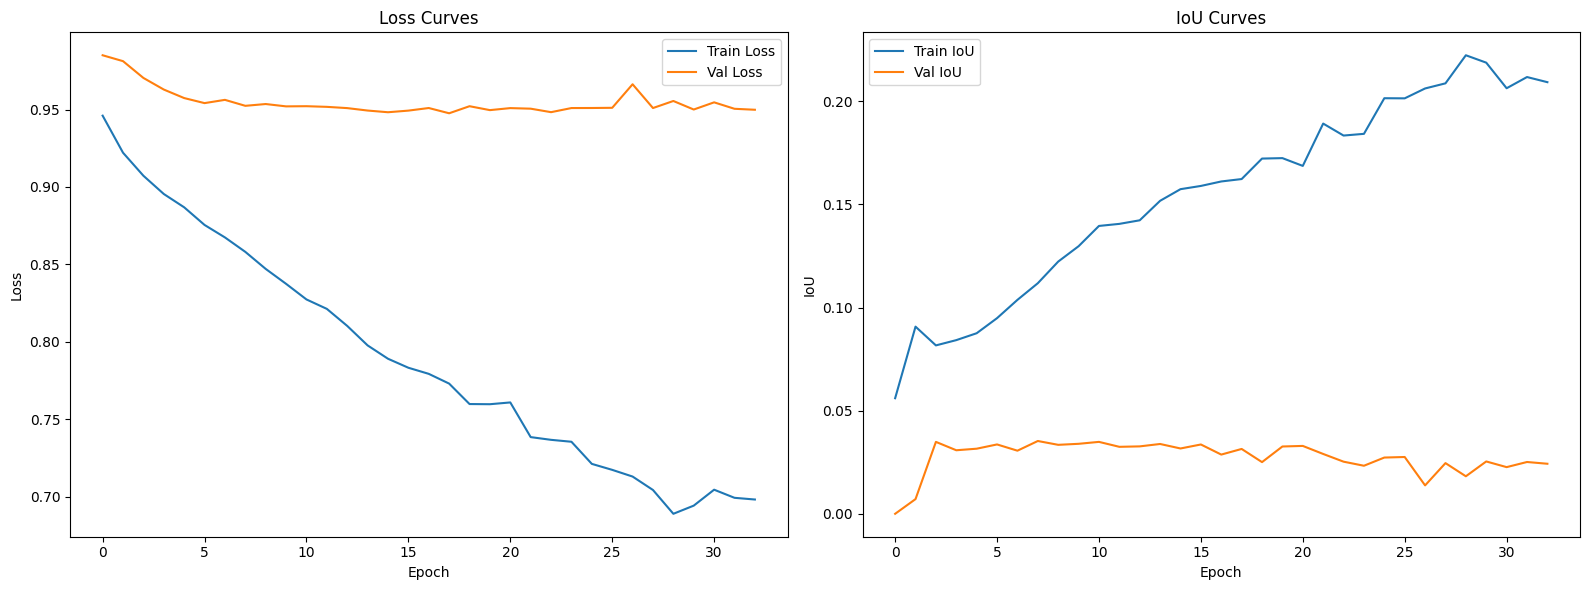

Evaluating on train set...


Evaluating Train: 100%|██████████| 14/14 [00:01<00:00,  9.71it/s]



Train Metrics:
  Average IoU: 0.1648
  Background IoU: 0.8903
  Wetland IoU: 0.1659
  Mean IoU: 0.5281
  Precision: 0.1707
  Recall: 0.8546
  F1 Score: 0.2845
Evaluating on validation set...


Evaluating Val: 100%|██████████| 5/5 [00:00<00:00, 10.30it/s]



Val Metrics:
  Average IoU: 0.0314
  Background IoU: 0.8715
  Wetland IoU: 0.0323
  Mean IoU: 0.4519
  Precision: 0.0331
  Recall: 0.5778
  F1 Score: 0.0625
Evaluating on test set...


Evaluating Test: 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]



Test Metrics:
  Average IoU: 0.1171
  Background IoU: 0.8670
  Wetland IoU: 0.1204
  Mean IoU: 0.4937
  Precision: 0.1308
  Recall: 0.6016
  F1 Score: 0.2149
Plotting confusion matrix...


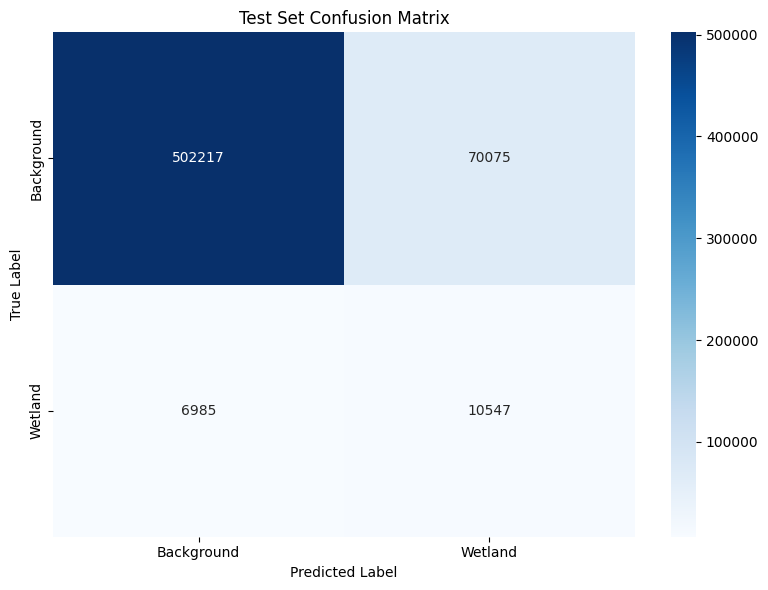

Visualizing train predictions...


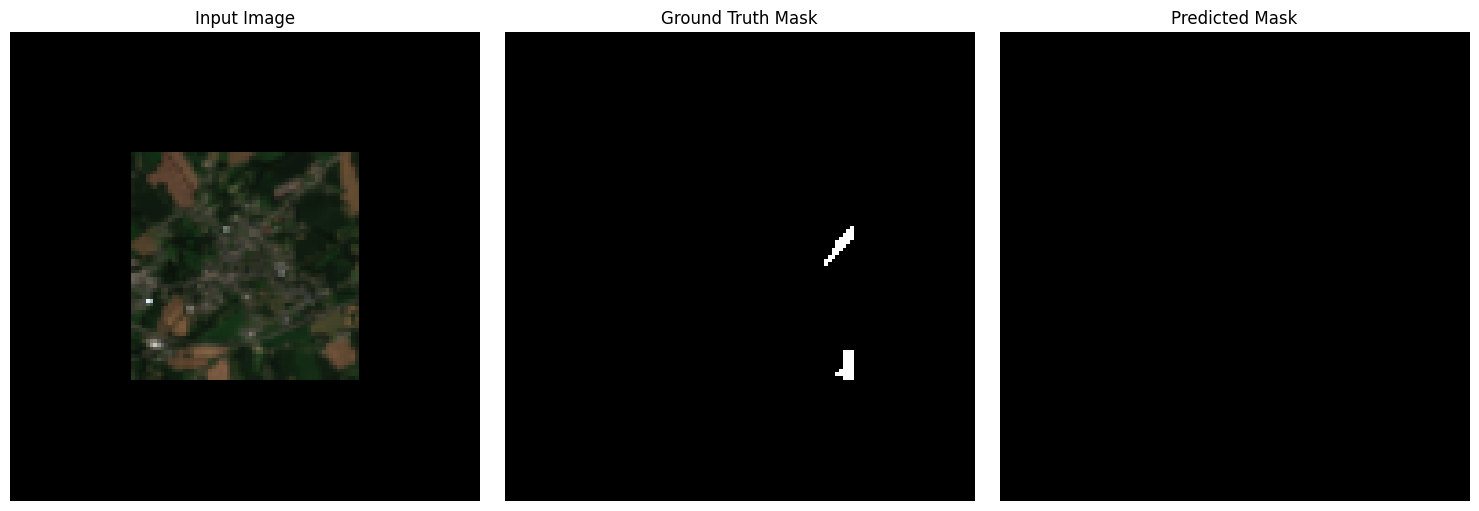

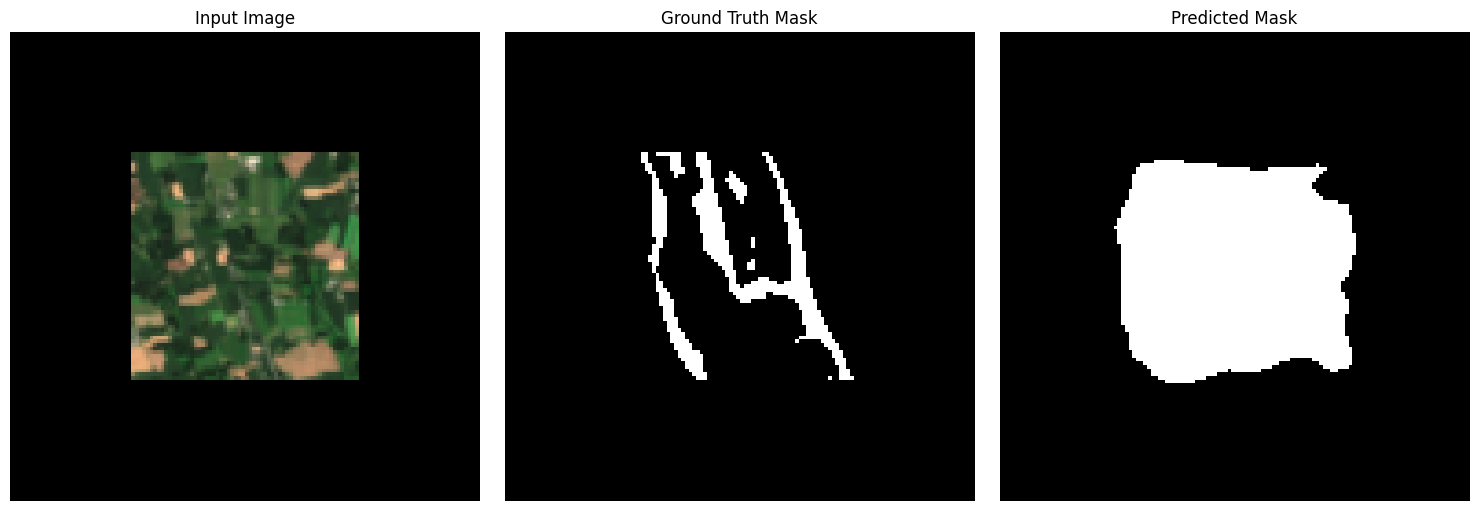

Visualizing test predictions...


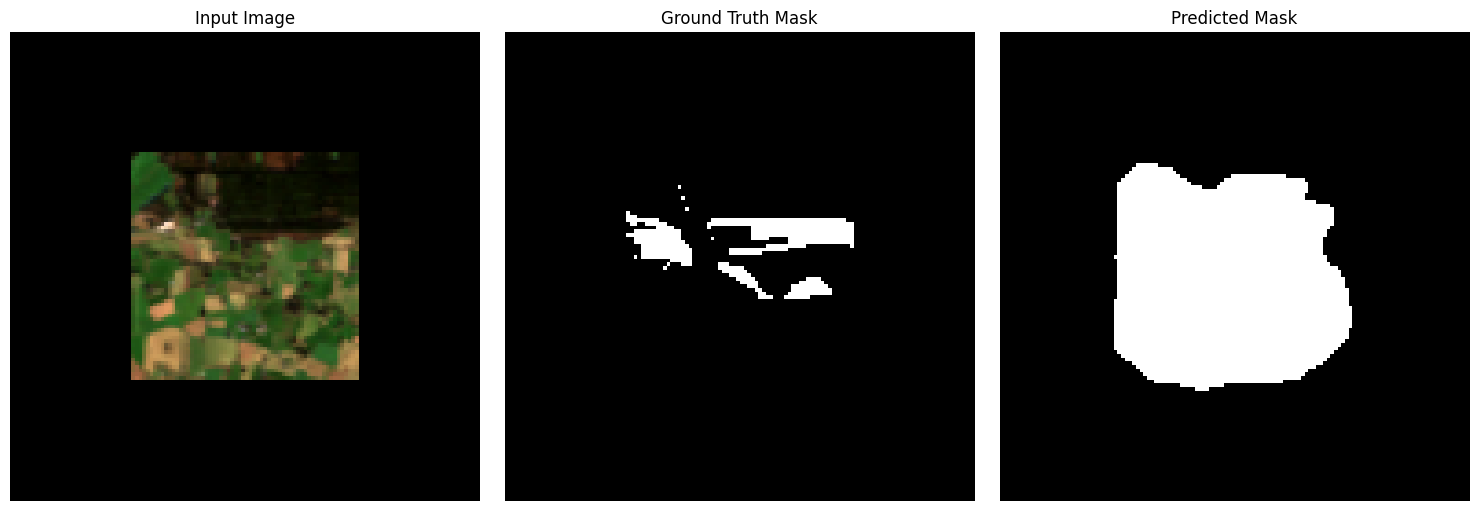

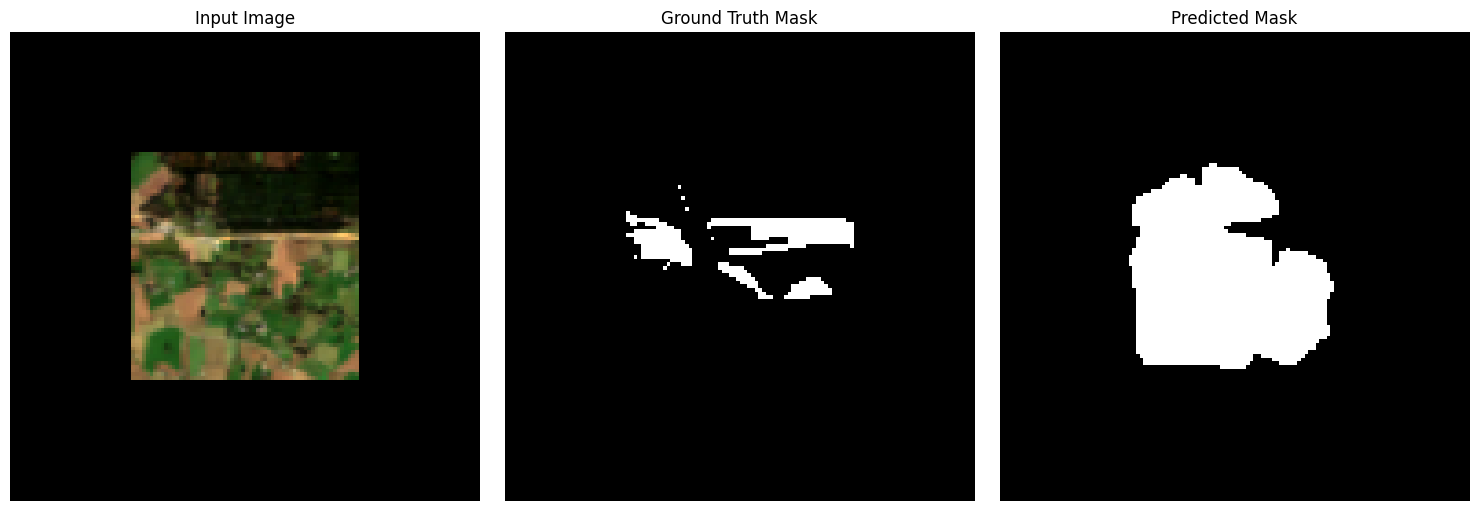

Completed DeepLabV3plus_TL_FrozenEncoder!


In [11]:
# Define the DeepLabV3+ model with frozen encoder only
import torch
import segmentation_models_pytorch as smp

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the model
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",  # Using ResNet34 backbone
    encoder_weights="imagenet",  # Pre-trained on ImageNet
    in_channels=3,  # RGB input
    classes=1,  # Binary segmentation (wetland vs background)
)

model = model.to(device)

# Freeze only the encoder
for param in model.encoder.parameters():
    param.requires_grad = False

# Keep decoder and segmentation head trainable
# This allows more adaptation to your specific task while leveraging 
# the pretrained feature extraction capabilities

# Verify parameter freezing
total_params = 0
trainable_params = 0
for param in model.parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

# Define loss function and optimizer (optimizing decoder and segmentation head)
criterion = smp.losses.DiceLoss('binary')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Now you can train using your existing functions
print("Model setup complete. Ready for training with frozen encoder.")

# Run training
model_name = "DeepLabV3plus_TL_FrozenEncoder"
model, train_losses, val_losses, train_ious, val_ious = train_model(
    model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=15
)
print(model)

# Plot training results
print("Plotting training results...")
plot_results(train_losses, val_losses, train_ious, val_ious)

# Evaluate on all datasets
print("Evaluating on train set...")
train_iou, train_cm, train_bg_iou, train_wetland_iou, train_mean_iou = evaluate_model(model, train_loader, name="Train")

print("Evaluating on validation set...")
val_iou, val_cm, val_bg_iou, val_wetland_iou, val_mean_iou = evaluate_model(model, val_loader, name="Val")

print("Evaluating on test set...")
test_iou, test_cm, test_bg_iou, test_wetland_iou, test_mean_iou = evaluate_model(model, test_loader, name="Test")

# Update the results dataframe
results_df = track_model_performance(
    results_df, model_name, len(train_losses),
    train_bg_iou, train_wetland_iou, train_mean_iou,
    val_bg_iou, val_wetland_iou, val_mean_iou,
    test_bg_iou, test_wetland_iou, test_mean_iou
)

# Plot confusion matrix and visualize predictions
print("Plotting confusion matrix...")
plot_confusion_matrix(test_cm, title="Test Set Confusion Matrix")

print("Visualizing train predictions...")
visualize_predictions(model, train_loader, num_samples=2)

print("Visualizing test predictions...")
visualize_predictions(model, test_loader, num_samples=2)

print(f"Completed {model_name}!")

**DeepLabV3+ Transfer Learning Modelling Summary**<br>

**Training Performance Patterns**<br>
The loss and IoU curves (Image 1) show consistent improvement in training performance, with training loss decreasing from 0.95 to 0.70 over 32 epochs. Training IoU increases steadily to approximately 0.22, indicating moderate learning on the training data. The validation loss remains relatively stable around 0.95, while validation IoU shows minimal improvement (hovering around 0.03), highlighting a persistent generalization gap.

**Classification Performance**<br>
The confusion matrix (Image 2) demonstrates moderate background classification (502,217 true negatives) but significant wetland over-prediction. With 10,547 true positive wetland pixels versus 70,075 false positives, the model shows a strong tendency to classify background as wetland. While 6,985 wetland pixels are missed, the high false positive rate indicates bias toward wetland prediction.

**Visual Prediction Analysis**<br>
The prediction visualizations (Images 3-4) confirm the over-segmentation issue. The first training sample shows no wetland detection, but the second sample demonstrates excessive wetland prediction. Test predictions show large blobs covering much more area than the actual wetland regions, indicating poor boundary precision and over-generalization of wetland features.

**Quantitative Metrics Summary**<br>
The evaluation metrics reveal modest performance with significant class imbalance:<br>
- Train set: Mean IoU of 0.53 (Background: 0.89, Wetland: 0.17)
- Validation set: Mean IoU of 0.45 (Background: 0.87, Wetland: 0.03)
- Test set: Mean IoU of 0.49 (Background: 0.87, Wetland: 0.12)

The Mean IoU of 0.49 on test data represents a modest improvement over some previous models but falls short of the full DeepLabV3+ implementation. With high recall (0.60) but low precision (0.13), the transfer learning approach exhibits similar over-prediction tendencies as seen in other models. Despite leveraging pre-trained encoder features, the limited trainable parameters (5.14%) appear insufficient for properly learning wetland boundaries while maintaining adequate background classification.

# Model Unet from scratch

**Small U-Net with Multi-Spectral Wetland Segmentation**<br>

**Data Preparation and Enhancement**<br>
This code implements a comprehensive wetland segmentation pipeline using multi-spectral satellite imagery. It includes specialized preprocessing for remote sensing data with dynamic band handling and calculation of vegetation (NDVI) and water (NDWI) indices to enhance feature representation.

**Custom Dataset Implementation**<br>
The WetlandsSegmentationDataset class supports variable numbers of spectral bands and intelligently integrates derived indices. It handles band normalization, augmentation application, and tensor formatting for model compatibility.

**Model Architecture**<br>
A lightweight U-Net implementation with skip connections is defined, featuring a simple encoder-decoder structure with double convolution blocks. The network balances performance and efficiency with approximately 128K parameters, making it suitable for limited computational resources.

**Loss Function Optimization**<br>
The implementation includes specialized Dice Loss functions that are particularly effective for handling class imbalance in segmentation tasks where wetland pixels may be significantly less common than background.

**Training Framework**<br>
The training pipeline incorporates early stopping, model checkpointing, and comprehensive performance tracking. It systematically evaluates model performance across training, validation, and test sets with appropriate metrics for segmentation quality assessment.

**Evaluation Metrics**<br>
Robust evaluation includes confusion matrix analysis, class-specific IoU calculation, and standard classification metrics. The framework tracks background and wetland IoU separately to provide insight into class-specific performance challenges.

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import rasterio
from sklearn.metrics import confusion_matrix, classification_report
import albumentations as A
import cv2
from tqdm import tqdm
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set paths - update these to match your Kaggle environment
DATA_DIR = "/kaggle/input/patches-img-seg-allbands/patches_data_allbands"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train/input")
TRAIN_MASK_DIR = os.path.join(DATA_DIR, "train/output")
VAL_IMG_DIR = os.path.join(DATA_DIR, "val/input")
VAL_MASK_DIR = os.path.join(DATA_DIR, "val/output")
TEST_IMG_DIR = os.path.join(DATA_DIR, "test/input")
TEST_MASK_DIR = os.path.join(DATA_DIR, "test/output")

# Define augmentations
def get_training_augmentation():
    """
    Apply training augmentations
    """
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """
    No augmentation for validation and test
    """
    return A.Compose([])

# Calculate NDVI: Normalized Difference Vegetation Index
def calculate_ndvi(nir, red):
    """Calculate NDVI from near-infrared and red bands"""
    # Avoid division by zero
    denominator = nir + red
    ndvi = np.zeros_like(denominator)
    valid_mask = denominator != 0
    ndvi[valid_mask] = (nir[valid_mask] - red[valid_mask]) / denominator[valid_mask]
    # Clip to [-1, 1] range
    ndvi = np.clip(ndvi, -1, 1)
    return ndvi

# Calculate NDWI: Normalized Difference Water Index
def calculate_ndwi(green, nir):
    """Calculate NDWI from green and near-infrared bands"""
    # Avoid division by zero
    denominator = green + nir
    ndwi = np.zeros_like(denominator)
    valid_mask = denominator != 0
    ndwi[valid_mask] = (green[valid_mask] - nir[valid_mask]) / denominator[valid_mask]
    # Clip to [-1, 1] range
    ndwi = np.clip(ndwi, -1, 1)
    return ndwi

# Define the dataset class
class WetlandsSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, in_channels=10, add_indices=True):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.in_channels = in_channels  # Original number of channels
        self.add_indices = add_indices  # Whether to add NDVI and NDWI
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith('.tif')])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])
        
        # Calculate total number of channels (original + NDVI + NDWI)
        self.total_channels = in_channels + (2 if add_indices else 0)
        
        # Make sure we have the same number of images and masks
        assert len(self.images) == len(self.masks), "Mismatch between images and masks"
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
        # Read the image using rasterio (get all available bands, up to in_channels)
        with rasterio.open(img_path) as src:
            num_bands = min(src.count, self.in_channels)
            image = np.zeros((num_bands, src.height, src.width), dtype=np.float32)
            
            for b in range(1, num_bands + 1):
                image[b-1] = src.read(b)
            
            # Extract bands for NDVI and NDWI calculation
            # Assuming band 4 is NIR, band 3 is Red, and band 2 is Green in a typical satellite image
            # Adjust these indices based on your actual band ordering
            if self.add_indices and num_bands >= 4:
                nir_band = image[3]  # NIR (band 4)
                red_band = image[2]  # Red (band 3)
                green_band = image[1]  # Green (band 2)
                
                # Calculate indices
                ndvi = calculate_ndvi(nir_band, red_band)
                ndwi = calculate_ndwi(green_band, nir_band)
                
                # Add indices as additional channels
                indices = np.stack([ndvi, ndwi])
                image = np.vstack([image, indices])
        
        # If we don't have enough original bands, pad with zeros
        if num_bands < self.in_channels:
            padding = np.zeros((self.in_channels - num_bands, src.height, src.width), dtype=np.float32)
            if self.add_indices:
                # If we've already added indices, just pad the original bands
                image_original = image[:num_bands]
                image_indices = image[num_bands:]
                image_original = np.vstack([image_original, padding])
                image = np.vstack([image_original, image_indices])
            else:
                # Otherwise just pad the whole thing
                image = np.vstack([image, padding])
        
        # Normalize image to [0, 1]
        for b in range(image.shape[0]):
            if np.max(image[b]) > np.min(image[b]):
                # Normalize each band independently
                image[b] = (image[b] - np.min(image[b])) / (np.max(image[b]) - np.min(image[b]))
        
        # Reshape to match expected format (H, W, C)
        image = np.transpose(image, (1, 2, 0))
        
        # Read mask
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.float32)
            
            # Ensure mask is binary (0 or 1)
            mask = (mask > 0).astype(np.float32)
        
        # Apply augmentations if specified
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert to PyTorch tensors
        image = torch.from_numpy(np.transpose(image, (2, 0, 1))).float()  # (C, H, W)
        mask = torch.from_numpy(mask).unsqueeze(0).float()  # (1, H, W)
        
        return image, mask

# Define the Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, predictions, targets):
        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = (predictions * targets).sum()
        union = predictions.sum() + targets.sum()
        
        # Calculate Dice coefficient and loss
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice

# # Define the combined BCE and Dice Loss for better performance
# class BCEDiceLoss(nn.Module):
#     def __init__(self, weight_bce=0.5, weight_dice=0.5):
#         super(BCEDiceLoss, self).__init__()
#         self.bce = nn.BCELoss()
#         self.dice = DiceLoss()
#         self.weight_bce = weight_bce
#         self.weight_dice = weight_dice
        
#     def forward(self, predictions, targets):
#         return self.weight_bce * self.bce(predictions, targets) + self.weight_dice * self.dice(predictions, targets)

# Define the Small UNet model
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class SmallUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()
        
        # Encoder
        self.encoder1 = DoubleConv(in_channels, 32)  # 62x62 -> 62x62
        self.pool1 = nn.MaxPool2d(2)  # 62x62 -> 31x31
        
        self.encoder2 = DoubleConv(32, 64)  # 31x31 -> 31x31
        self.pool2 = nn.MaxPool2d(2)  # 31x31 -> 15x15 (with padding)
        
        # Bottleneck
        self.bottleneck = DoubleConv(64, 128)  # 15x15 -> 15x15
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 15x15 -> 30x30
        self.decoder1 = DoubleConv(128, 64)  # 30x30 -> 30x30 (after concat)
        
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 30x30 -> 60x60
        self.decoder2 = DoubleConv(64, 32)  # 60x60 -> 60x60 (after concat)
        
        # Output layer
        self.outconv = nn.Conv2d(32, out_channels, kernel_size=1)  # 60x60 -> 60x60
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # 62x62x32
        x = self.pool1(enc1)  # 31x31x32
        
        enc2 = self.encoder2(x)  # 31x31x64
        x = self.pool2(enc2)  # 15x15x64
        
        # Bottleneck
        x = self.bottleneck(x)  # 15x15x128
        
        # Decoder
        x = self.upconv1(x)  # 30x30x64
        
        # Handle size mismatch for skip connection
        diff_y = enc2.size()[2] - x.size()[2]
        diff_x = enc2.size()[3] - x.size()[3]
        x = nn.functional.pad(x, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2])
        
        x = torch.cat([x, enc2], dim=1)  # 31x31x128
        x = self.decoder1(x)  # 31x31x64
        
        x = self.upconv2(x)  # 62x62x32
        
        # Handle size mismatch for skip connection
        diff_y = enc1.size()[2] - x.size()[2]
        diff_x = enc1.size()[3] - x.size()[3]
        x = nn.functional.pad(x, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2])
        
        x = torch.cat([x, enc1], dim=1)  # 62x62x64
        x = self.decoder2(x)  # 62x62x32
        
        # Output
        x = self.outconv(x)  # 62x62x1
        return self.sigmoid(x)

# IoU calculation function
def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    if union < smooth:
        return 1.0  # If both pred and target are empty, IoU is 1
    return (intersection + smooth) / (union + smooth)

# Function to compute confusion matrix and metrics
def compute_metrics(pred, target):
    pred_flat = pred.view(-1).cpu().numpy()
    target_flat = target.view(-1).cpu().numpy()
    
    # Convert probabilities to binary predictions
    pred_flat = (pred_flat > 0.5).astype(np.int64)
    target_flat = target_flat.astype(np.int64)
    
    # Compute confusion matrix
    cm = confusion_matrix(target_flat, pred_flat)
    
    # Get metrics from confusion matrix
    if cm.size == 4:  # Make sure confusion matrix has expected shape
        tn, fp, fn, tp = cm.ravel()
        total = tn + fp + fn + tp
        
        accuracy = (tp + tn) / total if total > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        bg_iou = tn / (tn + fp + fn) if (tn + fp + fn) > 0 else 0
        wetland_iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        mean_iou = (bg_iou + wetland_iou) / 2
    else:
        # Fallback if confusion matrix isn't as expected
        accuracy = precision = recall = f1 = bg_iou = wetland_iou = mean_iou = 0
        print(f"Warning: Confusion matrix shape unexpected: {cm.shape}")
    
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'bg_iou': bg_iou,
        'wetland_iou': wetland_iou,
        'mean_iou': mean_iou
    }

# Function to evaluate model
def evaluate_model(model, dataloader, criterion, phase="val"):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc=f"Evaluating {phase}"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track loss
            running_loss += loss.item() * inputs.size(0)
            
            # Store predictions and targets for metrics calculation
            all_preds.append(outputs.detach())
            all_targets.append(targets.detach())
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # Calculate metrics
    metrics = compute_metrics(all_preds, all_targets)
    metrics['loss'] = running_loss / len(dataloader.dataset)
    
    return metrics

# Add track model performance function
def track_model_performance(results_df, model_name, total_epochs, 
                           train_bg_iou, train_wetland_iou, train_mean_iou,
                           val_bg_iou, val_wetland_iou, val_mean_iou,
                           test_bg_iou, test_wetland_iou, test_mean_iou):
    # Create DataFrame if it doesn't exist
    if results_df is None:
        results_df = pd.DataFrame(columns=[
            'model_name', 'total_epochs',
            'train_bg_iou', 'train_wetland_iou', 'train_mean_iou',
            'val_bg_iou', 'val_wetland_iou', 'val_mean_iou',
            'test_bg_iou', 'test_wetland_iou', 'test_mean_iou'
        ])
    
    # Add new row with model results
    new_row = {
        'model_name': model_name,
        'total_epochs': total_epochs,
        'train_bg_iou': round(train_bg_iou*100,2),
        'train_wetland_iou': round(train_wetland_iou*100,2),
        'train_mean_iou': round(train_mean_iou*100,2),
        'val_bg_iou': round(val_bg_iou*100,2),
        'val_wetland_iou': round(val_wetland_iou*100,2),
        'val_mean_iou': round(val_mean_iou*100,2),
        'test_bg_iou': round(test_bg_iou*100,2),
        'test_wetland_iou': round(test_wetland_iou*100,2),
        'test_mean_iou': round(test_mean_iou*100,2)
    }
    
    # Append new row to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    
    return results_df

# Visualization function for original data
def visualize_original_data(dataset, idx=0):
    """
    Visualize original image and mask
    """
    image, mask = dataset[idx]
    
    # Convert tensors to numpy for visualization
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    
    # Display information about the data
    print(f"Image shape: {image_np.shape}")
    print(f"Mask shape: {mask_np.shape}")
    print(f"Number of bands: {image_np.shape[2]}")
    
    # RGB representation (first 3 bands)
    rgb_channels = min(3, image_np.shape[2])
    if rgb_channels == 3:
        print("Showing RGB representation (first 3 bands)")
    else:
        print(f"Showing first {rgb_channels} bands (not full RGB)")
    
    print("\nData statistics:")
    print(f"Image min value: {image_np.min():.4f}, max value: {image_np.max():.4f}")
    print(f"Mask min value: {mask_np.min():.4f}, max value: {mask_np.max():.4f}")
    print(f"Unique mask values: {np.unique(mask_np)}")

# Visualization function for augmented data
def visualize_augmented_data(dataset, idx=0):
    """
    Show statistics about augmented data samples
    """
    original_transform = dataset.transform
    dataset.transform = None
    orig_image, orig_mask = dataset[idx]
    dataset.transform = original_transform
    aug_image, aug_mask = dataset[idx]
    
    # Convert tensors to numpy for visualization
    orig_image_np = orig_image.permute(1, 2, 0).numpy()
    orig_mask_np = orig_mask.numpy()
    aug_image_np = aug_image.permute(1, 2, 0).numpy()
    aug_mask_np = aug_mask.numpy()
    
    print("Original vs Augmented Data:")
    print(f"Original image shape: {orig_image_np.shape}")
    print(f"Augmented image shape: {aug_image_np.shape}")
    print(f"Original mask shape: {orig_mask_np.shape}")
    print(f"Augmented mask shape: {aug_mask_np.shape}")
    
    # Check if augmentation was applied
    if np.array_equal(orig_image_np, aug_image_np) and np.array_equal(orig_mask_np, aug_mask_np):
        print("No augmentation was applied to this sample")
    else:
        print("Augmentation was successfully applied")

# Training function with early stopping
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, 
                model_name="SmallUNet", num_epochs=100, patience=15, results_df=None):
    # Initialize best model tracking
    best_val_mean_iou = 0.0
    patience_counter = 0
    best_model_path = f"best_{model_name.lower()}_model.pth"
    
    # Initialize history dictionaries
    history = {
        'train_loss': [], 'val_loss': [], 'test_loss': [],
        'train_bg_iou': [], 'train_wetland_iou': [], 'train_mean_iou': [],
        'val_bg_iou': [], 'val_wetland_iou': [], 'val_mean_iou': [],
        'test_bg_iou': [], 'test_wetland_iou': [], 'test_mean_iou': []
    }
    
    print(f"Starting training for {model_name} model...")
    print(f"Training for {num_epochs} epochs with patience {patience}")
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        
        for inputs, targets in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track loss and IoU
            running_loss += loss.item() * inputs.size(0)
            running_iou += iou_score(outputs, targets) * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_iou = running_iou / len(train_loader.dataset)
        
        # Evaluation phases
        train_metrics = evaluate_model(model, train_loader, criterion, "train")
        val_metrics = evaluate_model(model, val_loader, criterion, "val")
        test_metrics = evaluate_model(model, test_loader, criterion, "test")
        
        # Store metrics in history
        history['train_loss'].append(train_metrics['loss'])
        history['val_loss'].append(val_metrics['loss'])
        history['test_loss'].append(test_metrics['loss'])
        
        history['train_bg_iou'].append(train_metrics['bg_iou'])
        history['train_wetland_iou'].append(train_metrics['wetland_iou'])
        history['train_mean_iou'].append(train_metrics['mean_iou'])
        
        history['val_bg_iou'].append(val_metrics['bg_iou'])
        history['val_wetland_iou'].append(val_metrics['wetland_iou'])
        history['val_mean_iou'].append(val_metrics['mean_iou'])
        
        history['test_bg_iou'].append(test_metrics['bg_iou'])
        history['test_wetland_iou'].append(test_metrics['wetland_iou'])
        history['test_mean_iou'].append(test_metrics['mean_iou'])
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, BG IoU: {train_metrics['bg_iou']:.4f}, Wetland IoU: {train_metrics['wetland_iou']:.4f}, Mean IoU: {train_metrics['mean_iou']:.4f}")
        print(f"Val   - Loss: {val_metrics['loss']:.4f}, BG IoU: {val_metrics['bg_iou']:.4f}, Wetland IoU: {val_metrics['wetland_iou']:.4f}, Mean IoU: {val_metrics['mean_iou']:.4f}")
        print(f"Test  - Loss: {test_metrics['loss']:.4f}, BG IoU: {test_metrics['bg_iou']:.4f}, Wetland IoU: {test_metrics['wetland_iou']:.4f}, Mean IoU: {test_metrics['mean_iou']:.4f}")
        
        # Early stopping check
        if val_metrics['mean_iou'] > best_val_mean_iou:
            best_val_mean_iou = val_metrics['mean_iou']
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Val Mean IoU: {best_val_mean_iou:.4f}")
        else:
            patience_counter += 1
            print(f"Early stopping counter: {patience_counter}/{patience}")
            
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    
    # Load the best model before returning
    total_epochs = epoch + 1
    print(f"Training completed after {total_epochs} epochs")
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model from {best_model_path}")
    
    # Final evaluation
    print("\nFinal Evaluation:")
    train_metrics = evaluate_model(model, train_loader, criterion, "train")
    val_metrics = evaluate_model(model, val_loader, criterion, "val")
    test_metrics = evaluate_model(model, test_loader, criterion, "test")
    
    print(f"Train - BG IoU: {train_metrics['bg_iou']:.4f}, Wetland IoU: {train_metrics['wetland_iou']:.4f}, Mean IoU: {train_metrics['mean_iou']:.4f}")
    print(f"Val   - BG IoU: {val_metrics['bg_iou']:.4f}, Wetland IoU: {val_metrics['wetland_iou']:.4f}, Mean IoU: {val_metrics['mean_iou']:.4f}")
    print(f"Test  - BG IoU: {test_metrics['bg_iou']:.4f}, Wetland IoU: {test_metrics['wetland_iou']:.4f}, Mean IoU: {test_metrics['mean_iou']:.4f}")
    
    # Track model performance
    results_df = track_model_performance(
        results_df, model_name, total_epochs,
        train_metrics['bg_iou'], train_metrics['wetland_iou'], train_metrics['mean_iou'],
        val_metrics['bg_iou'], val_metrics['wetland_iou'], val_metrics['mean_iou'],
        test_metrics['bg_iou'], test_metrics['wetland_iou'], test_metrics['mean_iou']
    )
    
    return model, history, results_df


def print_classification_report(model, dataloader, phase="test"):
    """
    Print a detailed classification report for the model's predictions on the given dataloader.
    
    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): The DataLoader containing the dataset to evaluate.
        phase (str): The phase of evaluation (e.g., "train", "val", "test").
    
    Returns:
        report (str): The classification report.
        cm (np.ndarray): The confusion matrix.
        ious (tuple): Tuple containing (bg_iou, wetland_iou, mean_iou).
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc=f"Evaluating {phase}"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Store predictions and targets for metrics calculation
            all_preds.append(outputs.detach())
            all_targets.append(targets.detach())
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # Convert probabilities to binary predictions
    preds_flat = (all_preds > 0.5).float().view(-1).cpu().numpy()
    targets_flat = all_targets.view(-1).cpu().numpy()
    
    # Compute confusion matrix
    cm = confusion_matrix(targets_flat, preds_flat)
    
    # Compute classification report
    report = classification_report(targets_flat, preds_flat, target_names=["Background", "Wetland"])
    
    # Compute IoU scores
    bg_iou, wetland_iou, mean_iou = compute_metrics(all_preds, all_targets)['bg_iou'], \
                                    compute_metrics(all_preds, all_targets)['wetland_iou'], \
                                    compute_metrics(all_preds, all_targets)['mean_iou']
    
    # Print the results
    print(f"\n==== {phase.upper()} SET EVALUATION ====")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
    print(f"\nIoU Scores - Background: {bg_iou:.4f}, Wetland: {wetland_iou:.4f}, Mean: {mean_iou:.4f}")
    
    return report, cm, (bg_iou, wetland_iou, mean_iou)


# def main():
# """
# Main function to execute the training and evaluation of the SmallUNet model for wetland segmentation.
# """
#Initialize results DataFrame to track model performance
# results_df = pd.DataFrame(columns=[
#     'model_name', 'total_epochs',
#     'train_bg_iou', 'train_wetland_iou', 'train_mean_iou',
#     'val_bg_iou', 'val_wetland_iou', 'val_mean_iou',
#     'test_bg_iou', 'test_wetland_iou', 'test_mean_iou'
# ])

# print("Starting wetland segmentation with SmallUNet model...")

# First, check how many bands your TIF files actually have
try:
    img_path = os.path.join(TRAIN_IMG_DIR, os.listdir(TRAIN_IMG_DIR)[0])
    with rasterio.open(img_path) as src:
        actual_bands = src.count
        print(f"Your TIF files have {actual_bands} bands.")
except Exception as e:
    print(f"Error reading TIF file: {e}")
    print("Defaulting to 10 bands.")
    actual_bands = 10

# If your files have fewer than 4 bands, you can't calculate NDVI and NDWI
# Set add_indices to False in this case
add_indices = actual_bands >= 4

if not add_indices:
    print("WARNING: Your images don't have enough bands for NDVI and NDWI calculation.")
    print("The model will be adjusted to use only the available bands.")

try:
    # Create datasets with correct settings based on available bands
    print("Creating datasets...")
    train_dataset = WetlandsSegmentationDataset(
        TRAIN_IMG_DIR, TRAIN_MASK_DIR, 
        transform=get_training_augmentation(),
        in_channels=actual_bands,  # Use actual number of bands
        add_indices=add_indices    # Only add indices if we have enough bands
    )
    
    val_dataset = WetlandsSegmentationDataset(
        VAL_IMG_DIR, VAL_MASK_DIR, 
        transform=get_validation_augmentation(),
        in_channels=actual_bands,
        add_indices=add_indices
    )
    
    test_dataset = WetlandsSegmentationDataset(
        TEST_IMG_DIR, TEST_MASK_DIR, 
        transform=get_validation_augmentation(),
        in_channels=actual_bands,
        add_indices=add_indices
    )
    
    # Visualize original data and augmented data
    print("\n----- Original Data Visualization -----")
    visualize_original_data(train_dataset, idx=0)
    
    print("\n----- Augmented Data Visualization -----")
    visualize_augmented_data(train_dataset, idx=0)
    
    # Create dataloaders with error handling
    print("\nCreating dataloaders...")
    try:
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
        
        print(f"Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    except Exception as e:
        print(f"Error creating DataLoaders with num_workers=2: {e}")
        print("Trying with num_workers=0...")
        
        # Fallback to num_workers=0 if there's an issue
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)
        
        print(f"Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    
    # Check the dimensions of the input tensors
    input_sample = None
    for images, masks in train_loader:
        input_sample = images
        print(f"Input shape: {images.shape}")
        print(f"Mask shape: {masks.shape}")
        break
    
    # Calculate the actual number of channels after processing
    actual_channels = input_sample.shape[1]
    print(f"Actual number of channels in the processed data: {actual_channels}")
    
    # Train SmallUNet model
    print("\n===== Training SmallUNet Model =====")
    model_small = SmallUNet(in_channels=actual_channels, out_channels=1)
    model_small = model_small.to(device)
    
    # Print model summary
    print("Model architecture:")
    print(model_small)
    
    # Print number of parameters
    total_params = sum(p.numel() for p in model_small.parameters())
    trainable_params = sum(p.numel() for p in model_small.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Define loss function and optimizer
    criterion = DiceLoss()
    optimizer = optim.Adam(model_small.parameters(), lr=0.001)
    
    # Train the SmallUNet model
    print("\nStarting training...")
    model_small, history_small, results_df = train_model(
        model_small, train_loader, val_loader, test_loader,
        criterion, optimizer, model_name="SmallUNet", 
        num_epochs=100, patience=15, results_df=results_df
    )
    
    # Print detailed classification reports for all datasets with SmallUNet
    print("\n===== SmallUNet Detailed Evaluation =====")
    print("\n==== TRAIN SET EVALUATION ====")
    # train_report, train_cm, train_ious = print_classification_report(model_small, train_loader, "train")
    
    print("\n==== VALIDATION SET EVALUATION ====")
    # val_report, val_cm, val_ious = print_classification_report(model_small, val_loader, "validation")
    
    print("\n==== TEST SET EVALUATION ====")
    test_report, test_cm, test_ious = print_classification_report(model_small, test_loader, "test")
    
    # Print final summary with all IoU values for easy comparison
    print("\n===== FINAL EVALUATION SUMMARY =====")
    print(f"Train IoU (BG/Wetland/Mean): {train_ious[0]:.4f}/{train_ious[1]:.4f}/{train_ious[2]:.4f}")
    print(f"Validation IoU (BG/Wetland/Mean): {val_ious[0]:.4f}/{val_ious[1]:.4f}/{val_ious[2]:.4f}")
    print(f"Test IoU (BG/Wetland/Mean): {test_ious[0]:.4f}/{test_ious[1]:.4f}/{test_ious[2]:.4f}")
    
    # Display the performance tracking DataFrame
    print("\n===== MODEL PERFORMANCE TRACKING =====")
    print(results_df)
    
    # Save the performance tracking DataFrame
    # results_df.to_csv("model_performance_results.csv", index=False)
    print("Performance results saved to model_performance_results.csv")
    
    print("\nTraining and evaluation completed successfully!")
    
except Exception as e:
    print(f"Error during execution: {e}")
    import traceback
    traceback.print_exc()


# if __name__ == "__main__":
#     # Execute the main function
#     main()

Using device: cuda
Your TIF files have 10 bands.
Creating datasets...

----- Original Data Visualization -----
Image shape: (62, 62, 12)
Mask shape: (1, 62, 62)
Number of bands: 12
Showing RGB representation (first 3 bands)

Data statistics:
Image min value: 0.0000, max value: 1.0000
Mask min value: 0.0000, max value: 1.0000
Unique mask values: [0. 1.]

----- Augmented Data Visualization -----
Original vs Augmented Data:
Original image shape: (62, 62, 12)
Augmented image shape: (62, 62, 12)
Original mask shape: (1, 62, 62)
Augmented mask shape: (1, 62, 62)
Augmentation was successfully applied

Creating dataloaders...
Dataset sizes: Train=108, Val=36, Test=36
Input shape: torch.Size([8, 12, 62, 62])
Mask shape: torch.Size([8, 1, 62, 62])
Actual number of channels in the processed data: 12

===== Training SmallUNet Model =====
Model architecture:
SmallUNet(
  (encoder1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


Train - Loss: 0.8110, BG IoU: 0.1355, Wetland IoU: 0.1126, Mean IoU: 0.1240
Val   - Loss: 0.9416, BG IoU: 0.0734, Wetland IoU: 0.0312, Mean IoU: 0.0523
Test  - Loss: 0.7930, BG IoU: 0.0740, Wetland IoU: 0.1209, Mean IoU: 0.0974
Saved best model with Val Mean IoU: 0.0523
Epoch 2/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 13.87it/s]


Train - Loss: 0.7803, BG IoU: 0.4206, Wetland IoU: 0.1396, Mean IoU: 0.2801
Val   - Loss: 0.9447, BG IoU: 0.3455, Wetland IoU: 0.0281, Mean IoU: 0.1868
Test  - Loss: 0.8020, BG IoU: 0.2949, Wetland IoU: 0.1065, Mean IoU: 0.2007
Saved best model with Val Mean IoU: 0.1868
Epoch 3/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.28it/s]


Train - Loss: 0.7358, BG IoU: 0.5143, Wetland IoU: 0.1603, Mean IoU: 0.3373
Val   - Loss: 0.9484, BG IoU: 0.4102, Wetland IoU: 0.0255, Mean IoU: 0.2179
Test  - Loss: 0.7893, BG IoU: 0.4215, Wetland IoU: 0.1157, Mean IoU: 0.2686
Saved best model with Val Mean IoU: 0.2179
Epoch 4/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.95it/s]


Train - Loss: 0.7333, BG IoU: 0.6795, Wetland IoU: 0.1721, Mean IoU: 0.4258
Val   - Loss: 0.9385, BG IoU: 0.7788, Wetland IoU: 0.0316, Mean IoU: 0.4052
Test  - Loss: 0.7778, BG IoU: 0.5265, Wetland IoU: 0.1269, Mean IoU: 0.3267
Saved best model with Val Mean IoU: 0.4052
Epoch 5/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


Train - Loss: 0.7489, BG IoU: 0.4266, Wetland IoU: 0.1556, Mean IoU: 0.2911
Val   - Loss: 0.9424, BG IoU: 0.2493, Wetland IoU: 0.0298, Mean IoU: 0.1395
Test  - Loss: 0.7727, BG IoU: 0.2453, Wetland IoU: 0.1276, Mean IoU: 0.1865
Early stopping counter: 1/15
Epoch 6/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00,  9.70it/s]


Train - Loss: 0.7100, BG IoU: 0.6165, Wetland IoU: 0.1908, Mean IoU: 0.4036
Val   - Loss: 0.9453, BG IoU: 0.4973, Wetland IoU: 0.0279, Mean IoU: 0.2626
Test  - Loss: 0.7686, BG IoU: 0.4329, Wetland IoU: 0.1328, Mean IoU: 0.2828
Early stopping counter: 2/15
Epoch 7/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 10.17it/s]


Train - Loss: 0.7131, BG IoU: 0.6806, Wetland IoU: 0.1973, Mean IoU: 0.4390
Val   - Loss: 0.9321, BG IoU: 0.7397, Wetland IoU: 0.0338, Mean IoU: 0.3867
Test  - Loss: 0.7719, BG IoU: 0.4184, Wetland IoU: 0.1271, Mean IoU: 0.2728
Early stopping counter: 3/15
Epoch 8/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00,  8.48it/s]


Train - Loss: 0.7251, BG IoU: 0.5148, Wetland IoU: 0.1668, Mean IoU: 0.3408
Val   - Loss: 0.9435, BG IoU: 0.3310, Wetland IoU: 0.0288, Mean IoU: 0.1799
Test  - Loss: 0.7589, BG IoU: 0.3785, Wetland IoU: 0.1374, Mean IoU: 0.2580
Early stopping counter: 4/15
Epoch 9/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.19it/s]


Train - Loss: 0.7279, BG IoU: 0.5156, Wetland IoU: 0.1679, Mean IoU: 0.3417
Val   - Loss: 0.9410, BG IoU: 0.3406, Wetland IoU: 0.0302, Mean IoU: 0.1854
Test  - Loss: 0.7519, BG IoU: 0.4603, Wetland IoU: 0.1441, Mean IoU: 0.3022
Early stopping counter: 5/15
Epoch 10/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00,  9.93it/s]


Train - Loss: 0.6734, BG IoU: 0.6562, Wetland IoU: 0.2055, Mean IoU: 0.4308
Val   - Loss: 0.9439, BG IoU: 0.5737, Wetland IoU: 0.0266, Mean IoU: 0.3001
Test  - Loss: 0.7625, BG IoU: 0.5581, Wetland IoU: 0.1361, Mean IoU: 0.3471
Early stopping counter: 6/15
Epoch 11/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 15.05it/s]


Train - Loss: 0.6977, BG IoU: 0.6074, Wetland IoU: 0.1895, Mean IoU: 0.3985
Val   - Loss: 0.9476, BG IoU: 0.5116, Wetland IoU: 0.0257, Mean IoU: 0.2687
Test  - Loss: 0.7940, BG IoU: 0.5479, Wetland IoU: 0.1161, Mean IoU: 0.3320
Early stopping counter: 7/15
Epoch 12/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.62it/s]


Train - Loss: 0.6938, BG IoU: 0.8500, Wetland IoU: 0.2034, Mean IoU: 0.5267
Val   - Loss: 0.9393, BG IoU: 0.9021, Wetland IoU: 0.0292, Mean IoU: 0.4657
Test  - Loss: 0.7471, BG IoU: 0.7590, Wetland IoU: 0.1499, Mean IoU: 0.4544
Saved best model with Val Mean IoU: 0.4657
Epoch 13/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.66it/s]


Train - Loss: 0.7318, BG IoU: 0.5005, Wetland IoU: 0.1619, Mean IoU: 0.3312
Val   - Loss: 0.9419, BG IoU: 0.2901, Wetland IoU: 0.0295, Mean IoU: 0.1598
Test  - Loss: 0.7722, BG IoU: 0.4369, Wetland IoU: 0.1294, Mean IoU: 0.2832
Early stopping counter: 1/15
Epoch 14/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.90it/s]


Train - Loss: 0.7561, BG IoU: 0.8702, Wetland IoU: 0.1558, Mean IoU: 0.5130
Val   - Loss: 0.9648, BG IoU: 0.9378, Wetland IoU: 0.0105, Mean IoU: 0.4741
Test  - Loss: 0.8357, BG IoU: 0.8108, Wetland IoU: 0.0832, Mean IoU: 0.4470
Saved best model with Val Mean IoU: 0.4741
Epoch 15/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


Train - Loss: 0.6821, BG IoU: 0.8637, Wetland IoU: 0.1995, Mean IoU: 0.5316
Val   - Loss: 0.9635, BG IoU: 0.9397, Wetland IoU: 0.0171, Mean IoU: 0.4784
Test  - Loss: 0.7910, BG IoU: 0.8153, Wetland IoU: 0.1217, Mean IoU: 0.4685
Saved best model with Val Mean IoU: 0.4784
Epoch 16/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 15.62it/s]


Train - Loss: 0.6637, BG IoU: 0.7694, Wetland IoU: 0.2147, Mean IoU: 0.4921
Val   - Loss: 0.9385, BG IoU: 0.6084, Wetland IoU: 0.0316, Mean IoU: 0.3200
Test  - Loss: 0.7619, BG IoU: 0.6933, Wetland IoU: 0.1362, Mean IoU: 0.4148
Early stopping counter: 1/15
Epoch 17/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


Train - Loss: 0.6319, BG IoU: 0.7603, Wetland IoU: 0.2338, Mean IoU: 0.4970
Val   - Loss: 0.9622, BG IoU: 0.6230, Wetland IoU: 0.0185, Mean IoU: 0.3208
Test  - Loss: 0.8327, BG IoU: 0.6929, Wetland IoU: 0.0891, Mean IoU: 0.3910
Early stopping counter: 2/15
Epoch 18/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]


Train - Loss: 0.6509, BG IoU: 0.7975, Wetland IoU: 0.2209, Mean IoU: 0.5092
Val   - Loss: 0.9161, BG IoU: 0.8543, Wetland IoU: 0.0462, Mean IoU: 0.4503
Test  - Loss: 0.7664, BG IoU: 0.6890, Wetland IoU: 0.1338, Mean IoU: 0.4114
Early stopping counter: 3/15
Epoch 19/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.36it/s]


Train - Loss: 0.6374, BG IoU: 0.8334, Wetland IoU: 0.2372, Mean IoU: 0.5353
Val   - Loss: 0.9705, BG IoU: 0.7702, Wetland IoU: 0.0141, Mean IoU: 0.3922
Test  - Loss: 0.8293, BG IoU: 0.7248, Wetland IoU: 0.0922, Mean IoU: 0.4085
Early stopping counter: 4/15
Epoch 20/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Train - Loss: 0.6533, BG IoU: 0.7104, Wetland IoU: 0.2176, Mean IoU: 0.4640
Val   - Loss: 0.9351, BG IoU: 0.5855, Wetland IoU: 0.0341, Mean IoU: 0.3098
Test  - Loss: 0.7452, BG IoU: 0.6609, Wetland IoU: 0.1467, Mean IoU: 0.4038
Early stopping counter: 5/15
Epoch 21/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.46it/s]


Train - Loss: 0.6470, BG IoU: 0.8082, Wetland IoU: 0.2270, Mean IoU: 0.5176
Val   - Loss: 0.9262, BG IoU: 0.7745, Wetland IoU: 0.0391, Mean IoU: 0.4068
Test  - Loss: 0.7592, BG IoU: 0.7166, Wetland IoU: 0.1393, Mean IoU: 0.4280
Early stopping counter: 6/15
Epoch 22/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.11it/s]


Train - Loss: 0.5805, BG IoU: 0.8524, Wetland IoU: 0.2781, Mean IoU: 0.5653
Val   - Loss: 0.9541, BG IoU: 0.8067, Wetland IoU: 0.0229, Mean IoU: 0.4148
Test  - Loss: 0.8054, BG IoU: 0.7999, Wetland IoU: 0.1089, Mean IoU: 0.4544
Early stopping counter: 7/15
Epoch 23/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 13.80it/s]


Train - Loss: 0.6124, BG IoU: 0.8701, Wetland IoU: 0.2585, Mean IoU: 0.5643
Val   - Loss: 0.9403, BG IoU: 0.8585, Wetland IoU: 0.0301, Mean IoU: 0.4443
Test  - Loss: 0.7256, BG IoU: 0.8124, Wetland IoU: 0.1597, Mean IoU: 0.4861
Early stopping counter: 8/15
Epoch 24/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.74it/s]


Train - Loss: 0.5781, BG IoU: 0.7926, Wetland IoU: 0.2811, Mean IoU: 0.5368
Val   - Loss: 0.9466, BG IoU: 0.5579, Wetland IoU: 0.0273, Mean IoU: 0.2926
Test  - Loss: 0.7553, BG IoU: 0.6990, Wetland IoU: 0.1377, Mean IoU: 0.4184
Early stopping counter: 9/15
Epoch 25/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.47it/s]


Train - Loss: 0.5881, BG IoU: 0.8380, Wetland IoU: 0.2731, Mean IoU: 0.5556
Val   - Loss: 0.9646, BG IoU: 0.9085, Wetland IoU: 0.0205, Mean IoU: 0.4645
Test  - Loss: 0.7673, BG IoU: 0.7531, Wetland IoU: 0.1340, Mean IoU: 0.4436
Early stopping counter: 10/15
Epoch 26/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.05it/s]


Train - Loss: 0.6660, BG IoU: 0.8867, Wetland IoU: 0.2050, Mean IoU: 0.5458
Val   - Loss: 0.9213, BG IoU: 0.9002, Wetland IoU: 0.0421, Mean IoU: 0.4712
Test  - Loss: 0.8313, BG IoU: 0.8402, Wetland IoU: 0.0911, Mean IoU: 0.4656
Early stopping counter: 11/15
Epoch 27/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.88it/s]


Train - Loss: 0.6262, BG IoU: 0.8259, Wetland IoU: 0.2438, Mean IoU: 0.5348
Val   - Loss: 0.9690, BG IoU: 0.7689, Wetland IoU: 0.0151, Mean IoU: 0.3920
Test  - Loss: 0.8394, BG IoU: 0.7274, Wetland IoU: 0.0927, Mean IoU: 0.4100
Early stopping counter: 12/15
Epoch 28/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.39it/s]


Train - Loss: 0.5907, BG IoU: 0.8726, Wetland IoU: 0.2698, Mean IoU: 0.5712
Val   - Loss: 0.9426, BG IoU: 0.8562, Wetland IoU: 0.0291, Mean IoU: 0.4427
Test  - Loss: 0.7425, BG IoU: 0.8054, Wetland IoU: 0.1487, Mean IoU: 0.4770
Early stopping counter: 13/15
Epoch 29/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.44it/s]


Train - Loss: 0.5472, BG IoU: 0.8282, Wetland IoU: 0.3038, Mean IoU: 0.5660
Val   - Loss: 0.9333, BG IoU: 0.6169, Wetland IoU: 0.0343, Mean IoU: 0.3256
Test  - Loss: 0.8182, BG IoU: 0.7456, Wetland IoU: 0.0983, Mean IoU: 0.4220
Early stopping counter: 14/15
Epoch 30/100


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.05it/s]


Train - Loss: 0.5456, BG IoU: 0.8334, Wetland IoU: 0.3037, Mean IoU: 0.5686
Val   - Loss: 0.9485, BG IoU: 0.7367, Wetland IoU: 0.0265, Mean IoU: 0.3816
Test  - Loss: 0.8164, BG IoU: 0.7499, Wetland IoU: 0.0989, Mean IoU: 0.4244
Early stopping counter: 15/15
Early stopping triggered!
Training completed after 30 epochs
Loaded best model from best_smallunet_model.pth

Final Evaluation:


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


Train - BG IoU: 0.8650, Wetland IoU: 0.1902, Mean IoU: 0.5276
Val   - BG IoU: 0.9397, Wetland IoU: 0.0171, Mean IoU: 0.4784
Test  - BG IoU: 0.8153, Wetland IoU: 0.1217, Mean IoU: 0.4685

===== SmallUNet Detailed Evaluation =====

==== TRAIN SET EVALUATION ====

==== VALIDATION SET EVALUATION ====

==== TEST SET EVALUATION ====


Evaluating test: 100%|██████████| 5/5 [00:00<00:00, 14.49it/s]



==== TEST SET EVALUATION ====

Confusion Matrix:
[[110009  10843]
 [ 14078   3454]]

Classification Report:
              precision    recall  f1-score   support

  Background       0.89      0.91      0.90    120852
     Wetland       0.24      0.20      0.22     17532

    accuracy                           0.82    138384
   macro avg       0.56      0.55      0.56    138384
weighted avg       0.80      0.82      0.81    138384


IoU Scores - Background: 0.8153, Wetland: 0.1217, Mean: 0.4685

===== FINAL EVALUATION SUMMARY =====
Train IoU (BG/Wetland/Mean): 0.0560/0.0907/0.0816
Validation IoU (BG/Wetland/Mean): 0.0000/0.0071/0.0349
Test IoU (BG/Wetland/Mean): 0.8153/0.1217/0.4685

===== MODEL PERFORMANCE TRACKING =====
                       model_name total_epochs  train_bg_iou  \
0                 Unet_pretrained           88         99.31   
1           Unet_TL_FrozenEncoder           28         87.79   
2        DeepLabV3plus_pretrained           68         97.80   
3  DeepLabV3

**SmallUNet Modelling Summary**<br>

**Training Performance Patterns**<br>
The evaluation metrics reveal a notable discrepancy between training and test performance for the SmallUNet model. The extremely low training IoU (0.08 mean) compared to significantly higher test IoU (0.47 mean) suggests potential issues with the training process or data representation during training evaluation.

**Classification Performance**<br>
The confusion matrix shows reasonable background classification (110,009 true negatives) but significant challenges with wetland detection. With only 3,454 true positive wetland pixels versus 14,078 false negatives and 10,843 false positives, the model struggles with wetland class representation, producing both false positives and missed detections.

**Visual Prediction Analysis**<br>
While no visual prediction examples are provided, the quantitative metrics suggest the model would demonstrate moderate background segmentation but poor wetland boundary delineation. The low wetland IoU (0.12) indicates the model would likely miss significant portions of wetland regions or inaccurately predict their boundaries.

**Quantitative Metrics Summary**<br>
The evaluation metrics highlight an unusual performance pattern across datasets:<br>
- Train set: Poor performance (Mean IoU: 0.08, Background: 0.06, Wetland: 0.09)
- Validation set: Extremely poor performance (Mean IoU: 0.03, Background: 0.00, Wetland: 0.01)
- Test set: Moderate performance (Mean IoU: 0.47, Background: 0.82, Wetland: 0.12)

The stark contrast between test and training/validation metrics suggests possible data handling inconsistencies or evaluation methodology differences. The model demonstrates reasonable background segmentation on the test set (0.82 IoU) but continues to struggle with wetland identification (0.12 IoU). The overall weighted F1 score of 0.81 is heavily influenced by the dominant background class performance rather than effective wetland segmentation.

# Results

In [13]:
# Display the results dataframe
print("\nModel Performance Summary:")
display(results_df.sort_values(by="test_mean_iou",ascending=False))


Model Performance Summary:


,model_name,total_epochs,train_bg_iou,train_wetland_iou,train_mean_iou,val_bg_iou,val_wetland_iou,val_mean_iou,test_bg_iou,test_wetland_iou,test_mean_iou
2,DeepLabV3plus_pretrained,68,97.80,42.60,70.20,97.49,8.29,52.89,95.40,10.02,52.71
0,Unet_pretrained,88,99.31,76.40,87.85,97.90,6.71,52.31,96.25,5.34,50.80
3,DeepLabV3plus_TL_FrozenEncoder,33,89.03,16.59,52.81,87.15,3.23,45.19,86.70,12.04,49.37
1,Unet_TL_FrozenEncoder,28,87.79,16.30,52.05,85.13,3.03,44.08,84.73,11.53,48.13
4,SmallUNet,30,86.50,19.02,52.76,93.97,1.71,47.84,81.53,12.17,46.85


**Comparative Analysis of Wetland Segmentation Models**<br>

**Model Performance Ranking**<br>
Based on test mean IoU (overall segmentation quality), the models rank as follows:
1. DeepLabV3Plus_pretrained (52.71%) - Fine-tuned model showing superior performance
2. Unet_pretrained (50.80%) - Fine-tuned model with strong overall segmentation
3. DeepLabV3Plus_TL_FrozenEncoder (49.37%) - Transfer learning approach with frozen encoder
4. Unet_TL_FrozenEncoder (48.13%) - Transfer learning approach with frozen encoder
5. SmallUNet (46.85%) - Lightweight model trained from scratch

**Best Model Analysis**<br>
The DeepLabV3Plus_pretrained model demonstrates the best performance with a mean IoU of 52.71%. It achieves excellent background segmentation (95.40%) while maintaining reasonable wetland detection (10.02%). This fine-tuned model leverages pre-trained weights without freezing layers, allowing for comprehensive adaptation to the wetland domain.

**Common Challenges**<br>
All models show a significant imbalance between background and wetland IoU scores. This consistent pattern indicates:
1. Class imbalance in the training data (wetlands likely represent a small portion of images)
2. Difficulty in distinguishing wetland boundaries from surrounding terrain
3. Limited spectral information for robust wetland identification

**Transfer Learning Observations**<br>
Models with frozen encoders (transfer learning approach) show slight performance degradation compared to their fully fine-tuned counterparts. However, they still outperform the lightweight SmallUNet, demonstrating the value of pre-trained features even with limited adaptation capacity.

**Future Directions**<br>
1. Incorporate additional spectral indices beyond RGB for better wetland characterization
2. Explore ensemble approaches combining strengths of multiple architectures
3. Increase the diversity and quantity of training data to improve generalization
4. Investigate region-specific models that account for different wetland types and characteristics

The results demonstrate that semantic segmentation of wetlands remains challenging, but pre-trained models with domain adaptation offer the most promising approach for accurate delineation.